In [22]:
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from datetime import datetime
import hydra
from hydra import initialize, compose
from hydra.utils import instantiate
import pandas as pd

# Import your project specific modules
from scripts.run import setup_model
from model.rbm.rbm_two_partite import RBM_TwoPartite
from utils.dwave.physics import joint_energy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Configuration
OUTPUT_DIR = "./wandb-outputs/dwave_data_campaign"
PROCESSED_DIR = "./wandb-outputs/dwave_processed"
INCIDENCE_ENERGIES = [1000, 50000, 100000, 200000, 300000]
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Plot styling
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

In [8]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
cfg=compose(config_name="config.yaml")
self = setup_model(cfg)


dummy_data = torch.zeros(1, cfg.rbm.latent_nodes_per_p).to(self.device)
CHECKPOINT_FILE = "/home/leozhu/CaloQuVAE/wandb-outputs/run_2025-11-15_19-47-10_RBM_TwoPartite/training_checkpoint.h5"
rbm = RBM_TwoPartite(cfg, data=dummy_data)

try:
    # Load the latest epoch (epoch=None)
    loaded_epoch = rbm.load_checkpoint(CHECKPOINT_FILE, epoch=None) 
    print(f"Successfully loaded checkpoint from epoch {loaded_epoch}.")
except Exception as e:
    print(f"Error loading checkpoint: {e}")
device = rbm.device


[01:26:37.276] INFO   data.dataManager                                  Loading ATLAS dataset: AtlasCustom1
[01:26:38.341] INFO   data.atlas                                        Using Linear Binning for Custom ATLAS Dataset
[01:26:38.458] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f785ff29e20>: 80000 events, 157 batches
[01:26:38.459] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f785ff15df0>: 10000 events, 10 batches
[01:26:38.460] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f785ff14d10>: 10000 events, 10 batches
[01:26:38.460] INFO   model.modelCreator                                ::Creating Model
[01:26:38.516] INFO   model.rbm.zephyr                                  RBM is configured to be fully connected.
[01:26:38.518] INFO   model.rbm.rbm_fulltorch                           RBMTorc

Using conditional latent size in decoder
cuda:1


[01:26:38.753] INFO   model.rbm.rbm_two_partite                         Initializing RBM parameters with std: 0.0001
[01:26:38.756] INFO   model.rbm.rbm_two_partite                         Loading parameters from epoch_1999...
[01:26:38.760] INFO   model.rbm.rbm_two_partite                         Loaded persistent chains.
[01:26:38.760] INFO   model.rbm.rbm_two_partite                         Restoring RNG states...


Successfully loaded checkpoint from epoch 1999.


In [6]:
aggregated_data = {}

for energy in INCIDENCE_ENERGIES:
    print(f"--- Processing Energy: {energy} ---")
    aggregated_data[energy] = {
        'careful': {'v': [], 'h': [], 'beta': [], 'time': []},
        'fast': {'v': [], 'h': [], 'beta': [], 'time': []},
        'drifted': {'v': [], 'h': [], 'beta': [], 'time': []}
    }
    
    # Find all files for this energy
    pattern = os.path.join(OUTPUT_DIR, f"samples_E{energy}_*.npz")
    files = sorted(glob.glob(pattern))
    
    for f_path in files:
        try:
            data = np.load(f_path, allow_pickle=True)
            mode_str = str(data['mode'])
            
            # Map mode strings to our keys
            if 'drifted' in mode_str:
                key = 'drifted'
            elif 'fast' in mode_str:
                key = 'fast'
            else:
                key = 'careful'
                
            # Append data
            aggregated_data[energy][key]['v'].append(data['v_samples'])
            aggregated_data[energy][key]['h'].append(data['h_samples'])
            
            # Metadata requires handling scalar vs array
            # We repeat scalar metadata to match sample count for easier plotting later if needed
            n_samples = data['v_samples'].shape[0]
            
            # Extract timestamp from filename for sorting/plotting
            # Filename fmt: samples_E{val}_{mode}_{idx}_{YYYYMMDD_HHMMSS}.npz
            ts_str = f_path.split('_')[-2] + "_" + f_path.split('_')[-1].replace(".npz", "")
            try:
                dt_obj = datetime.strptime(ts_str, "%Y%m%d_%H%M%S")
            except:
                dt_obj = datetime.now() # Fallback
                
            aggregated_data[energy][key]['beta'].append(np.full(n_samples, data['beta_final']))
            aggregated_data[energy][key]['time'].append([dt_obj] * n_samples)
            
        except Exception as e:
            print(f"Failed to load {f_path}: {e}")

    # Concatenate and Save
    for key in ['careful', 'fast', 'drifted']:
        if len(aggregated_data[energy][key]['v']) > 0:
            v_concat = np.concatenate(aggregated_data[energy][key]['v'])
            h_concat = np.concatenate(aggregated_data[energy][key]['h'])
            beta_concat = np.concatenate(aggregated_data[energy][key]['beta'])
            
            # Flattens the list of lists of timestamps
            time_concat = [t for batch in aggregated_data[energy][key]['time'] for t in batch] 
            
            save_name = os.path.join(PROCESSED_DIR, f"combined_E{energy}_{key}.npz")
            np.savez_compressed(
                save_name, 
                v_samples=v_concat, 
                h_samples=h_concat, 
                beta=beta_concat,
                timestamps=time_concat
            )
            print(f"  Saved {key}: {v_concat.shape[0]} samples -> {save_name}")
        else:
            print(f"  No data for {key}")

--- Processing Energy: 1000 ---
  Saved careful: 3072 samples -> ./wandb-outputs/dwave_processed/combined_E1000_careful.npz
  Saved fast: 3072 samples -> ./wandb-outputs/dwave_processed/combined_E1000_fast.npz
  Saved drifted: 512 samples -> ./wandb-outputs/dwave_processed/combined_E1000_drifted.npz
--- Processing Energy: 50000 ---
  Saved careful: 3072 samples -> ./wandb-outputs/dwave_processed/combined_E50000_careful.npz
  Saved fast: 3072 samples -> ./wandb-outputs/dwave_processed/combined_E50000_fast.npz
  No data for drifted
--- Processing Energy: 100000 ---
  Saved careful: 3072 samples -> ./wandb-outputs/dwave_processed/combined_E100000_careful.npz
  Saved fast: 3072 samples -> ./wandb-outputs/dwave_processed/combined_E100000_fast.npz
  Saved drifted: 256 samples -> ./wandb-outputs/dwave_processed/combined_E100000_drifted.npz
--- Processing Energy: 200000 ---
  Saved careful: 2304 samples -> ./wandb-outputs/dwave_processed/combined_E200000_careful.npz
  Saved fast: 3072 samples 

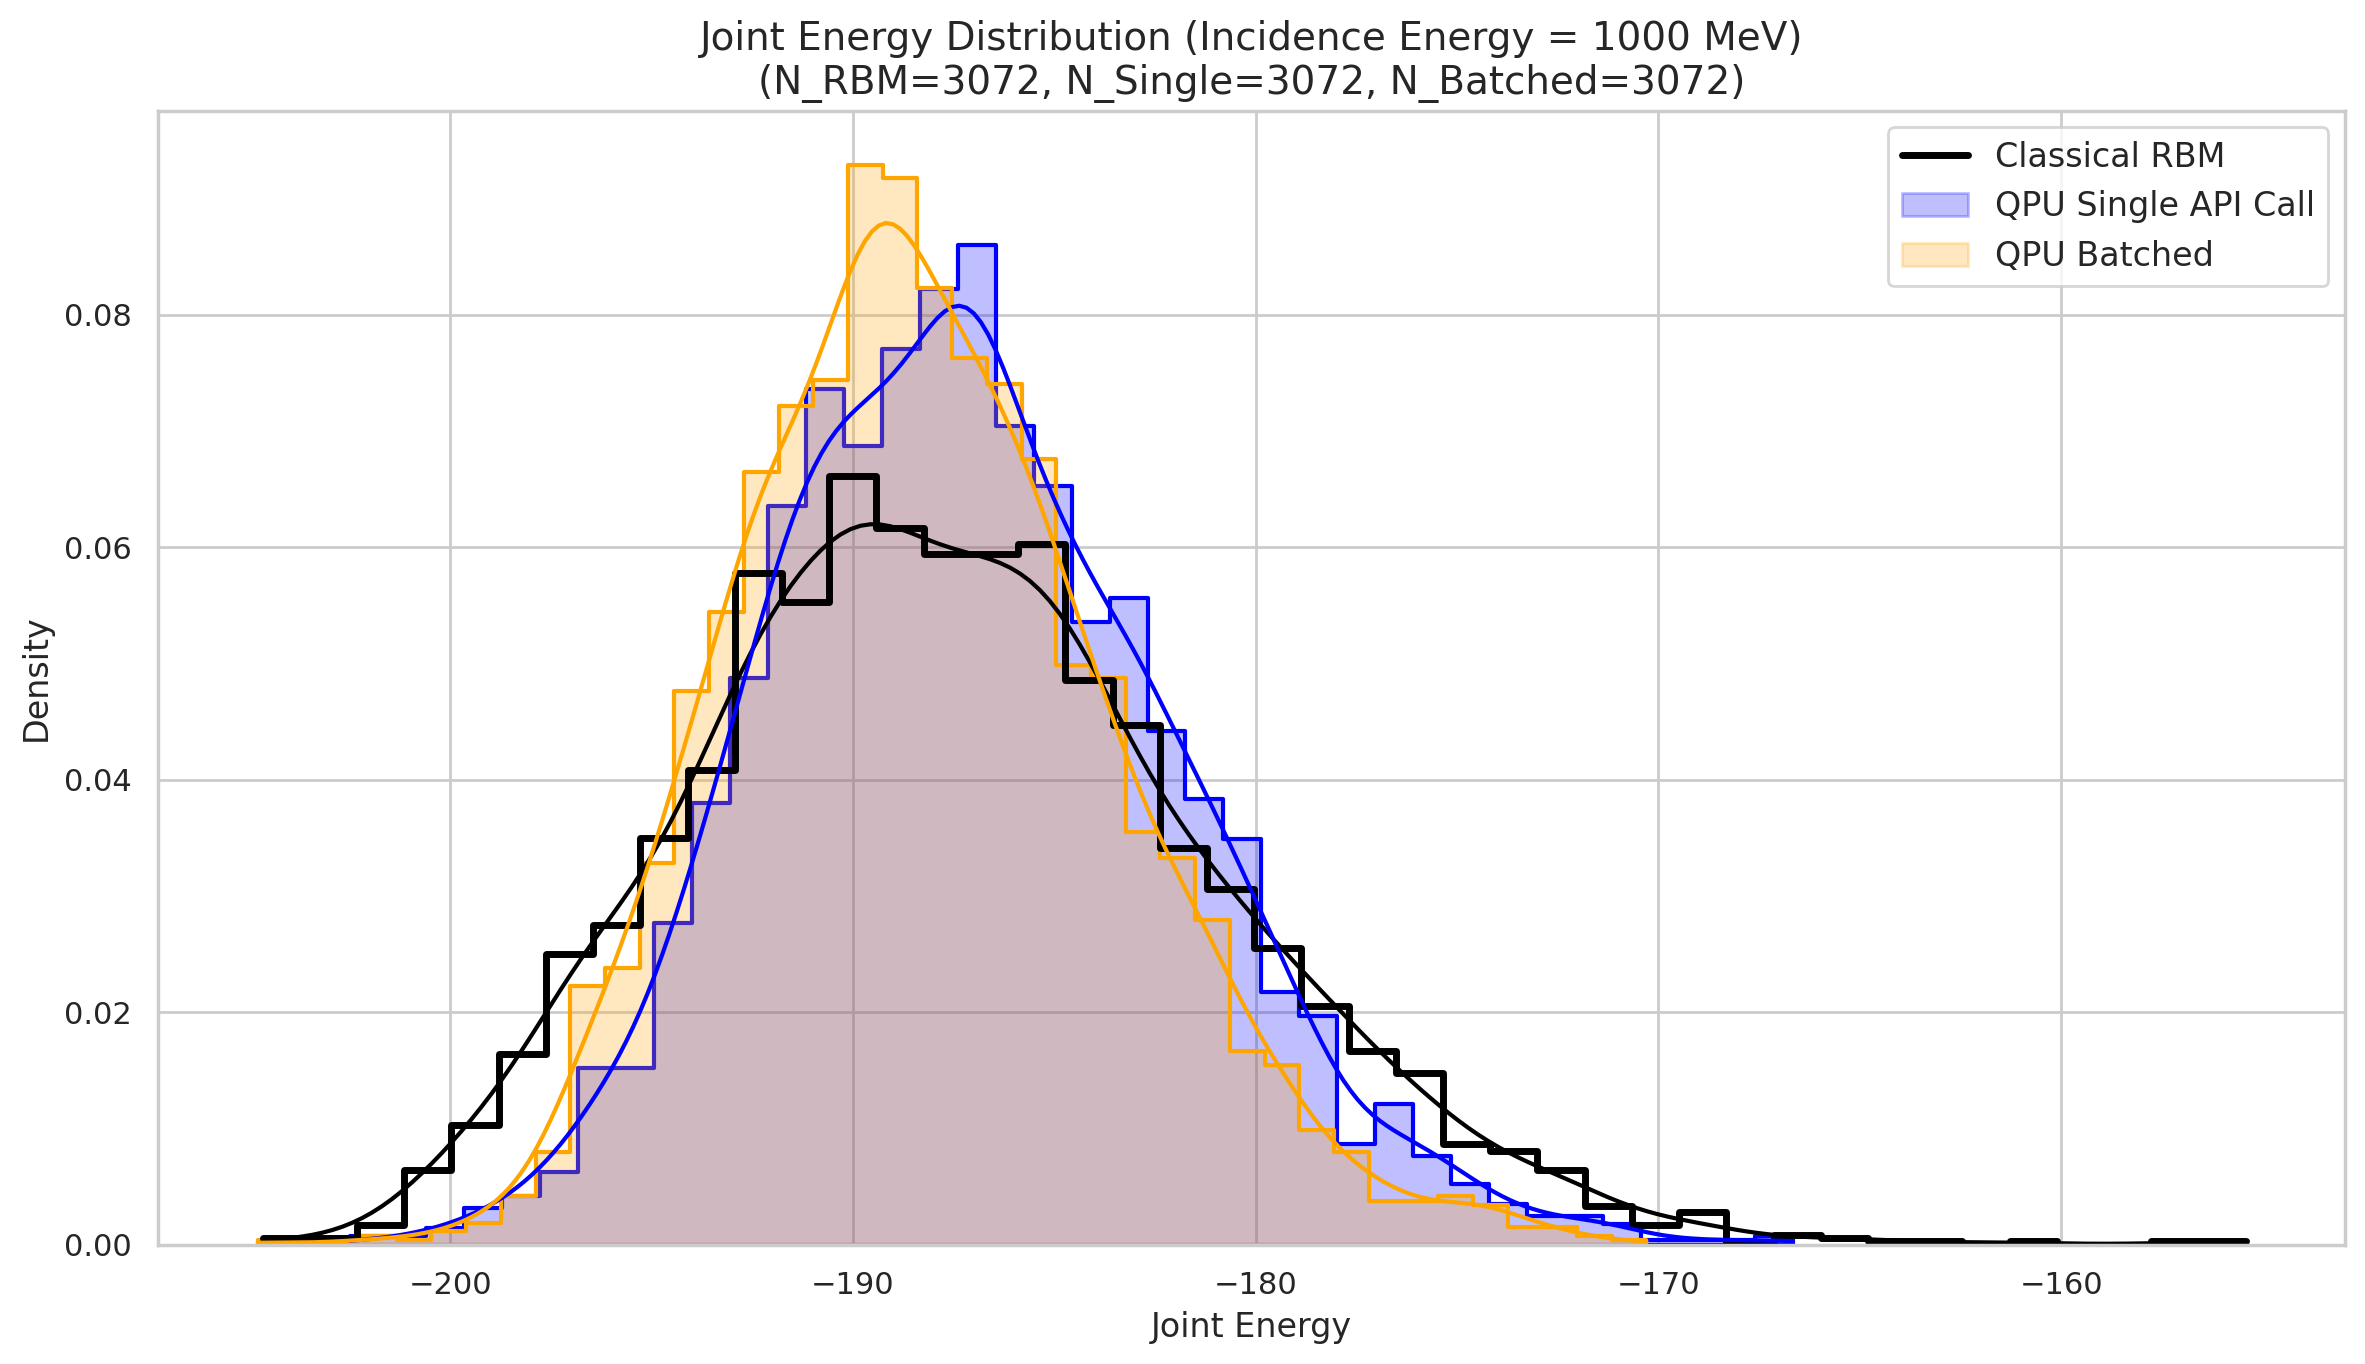

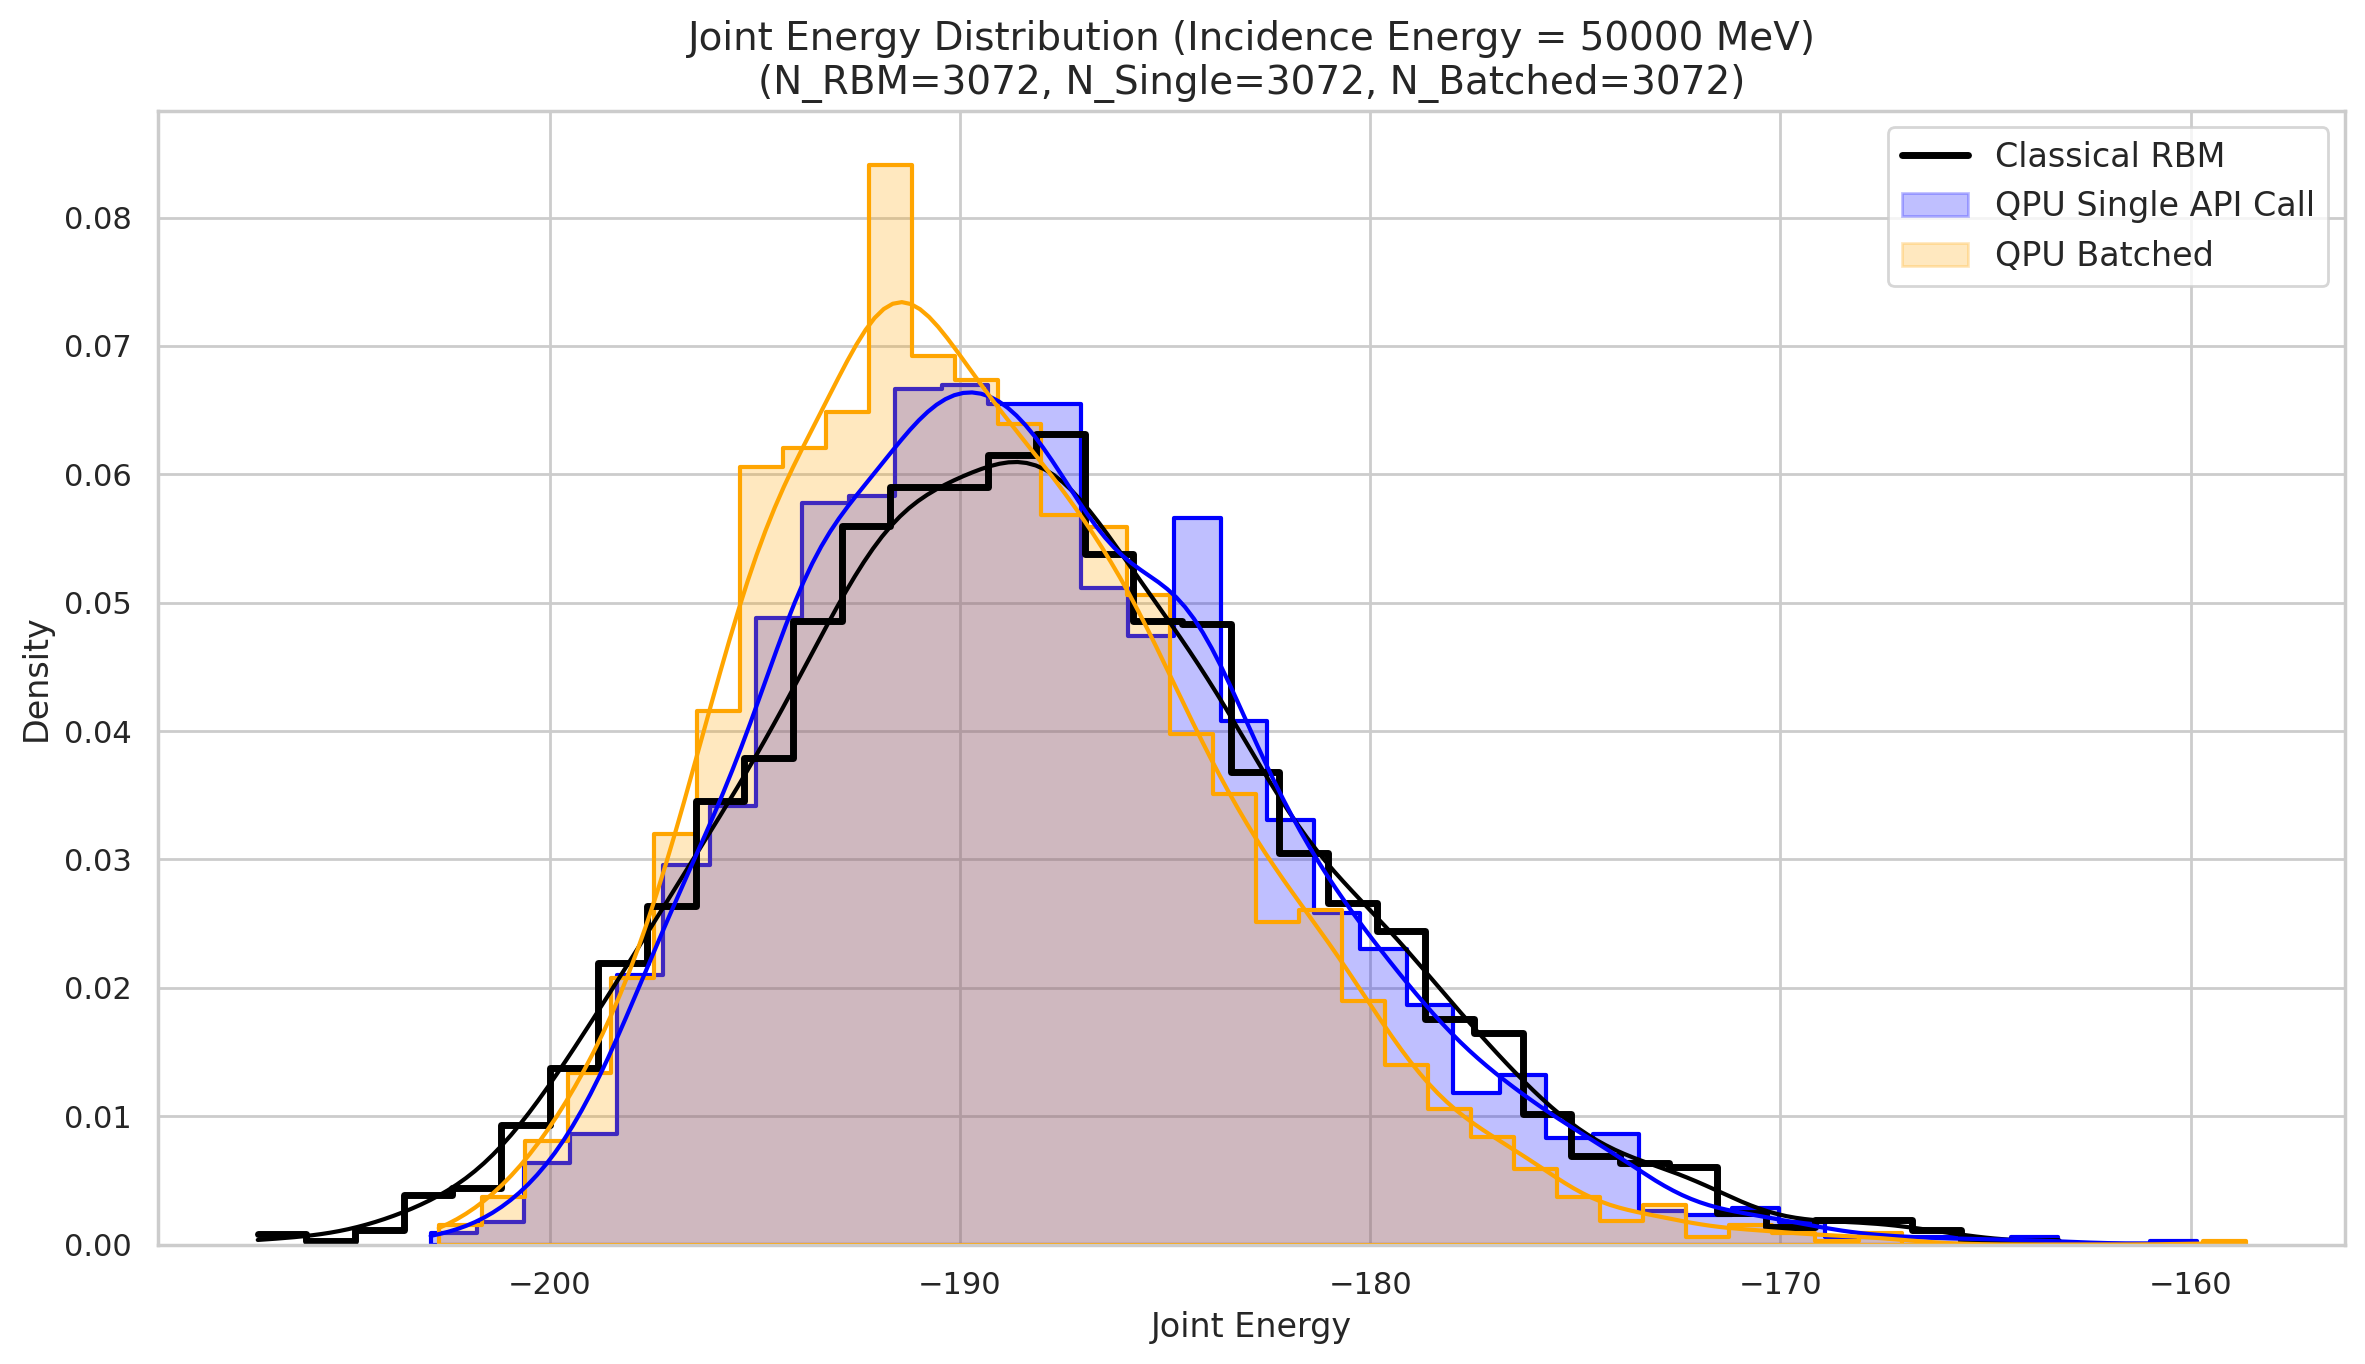

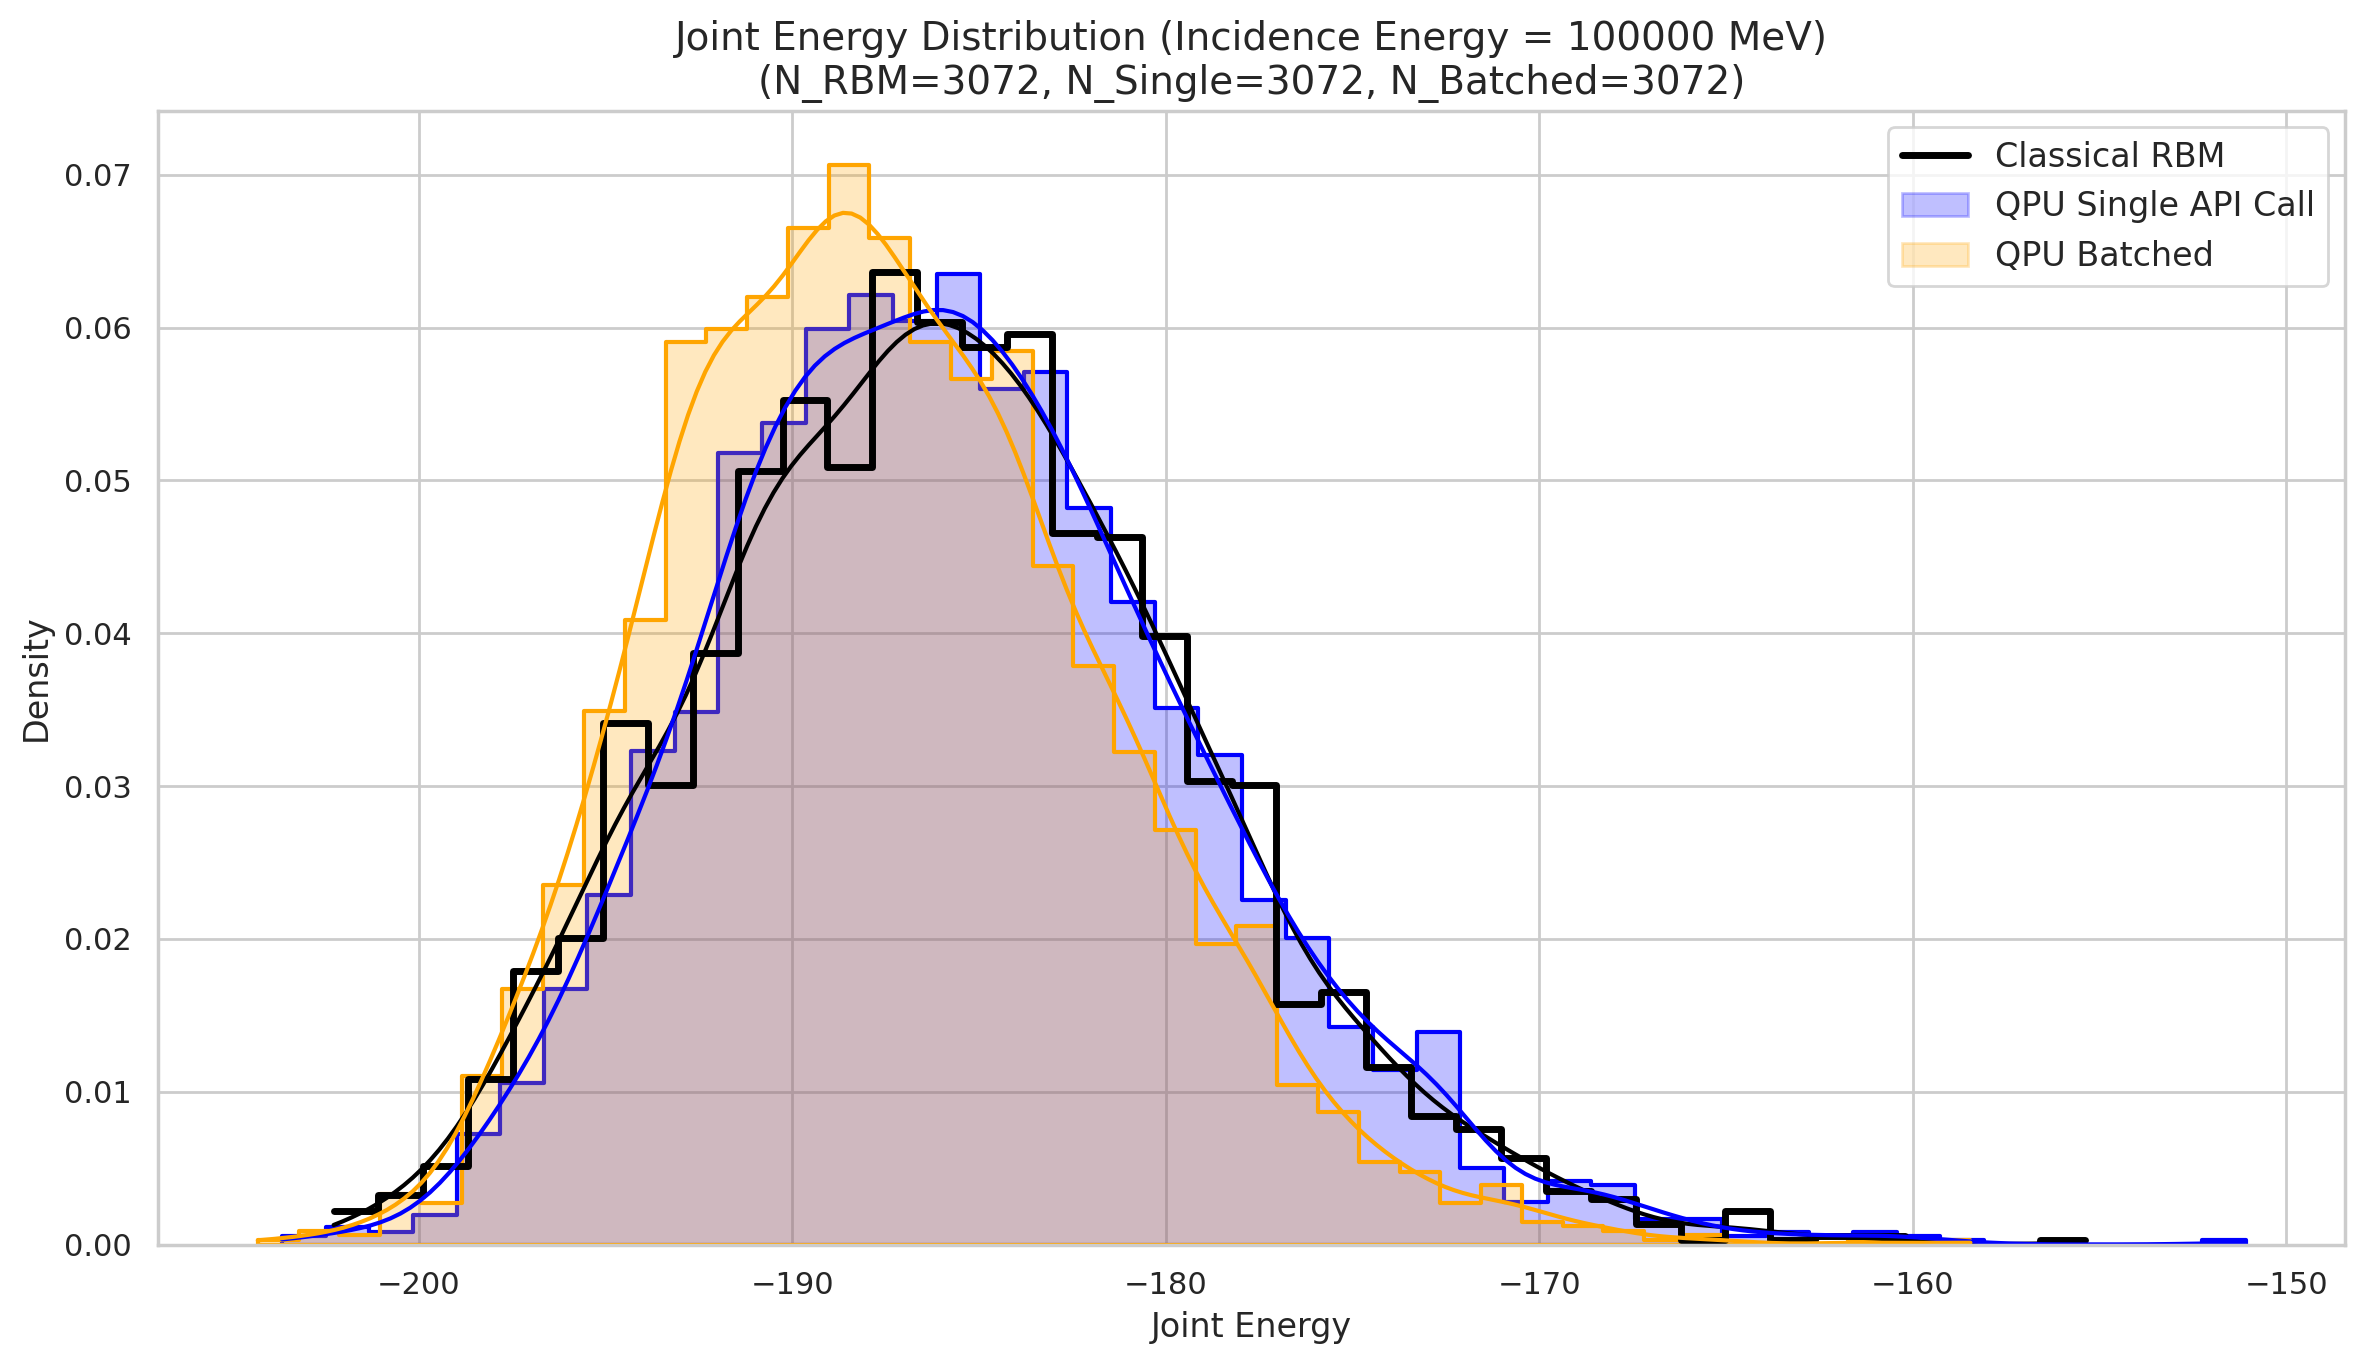

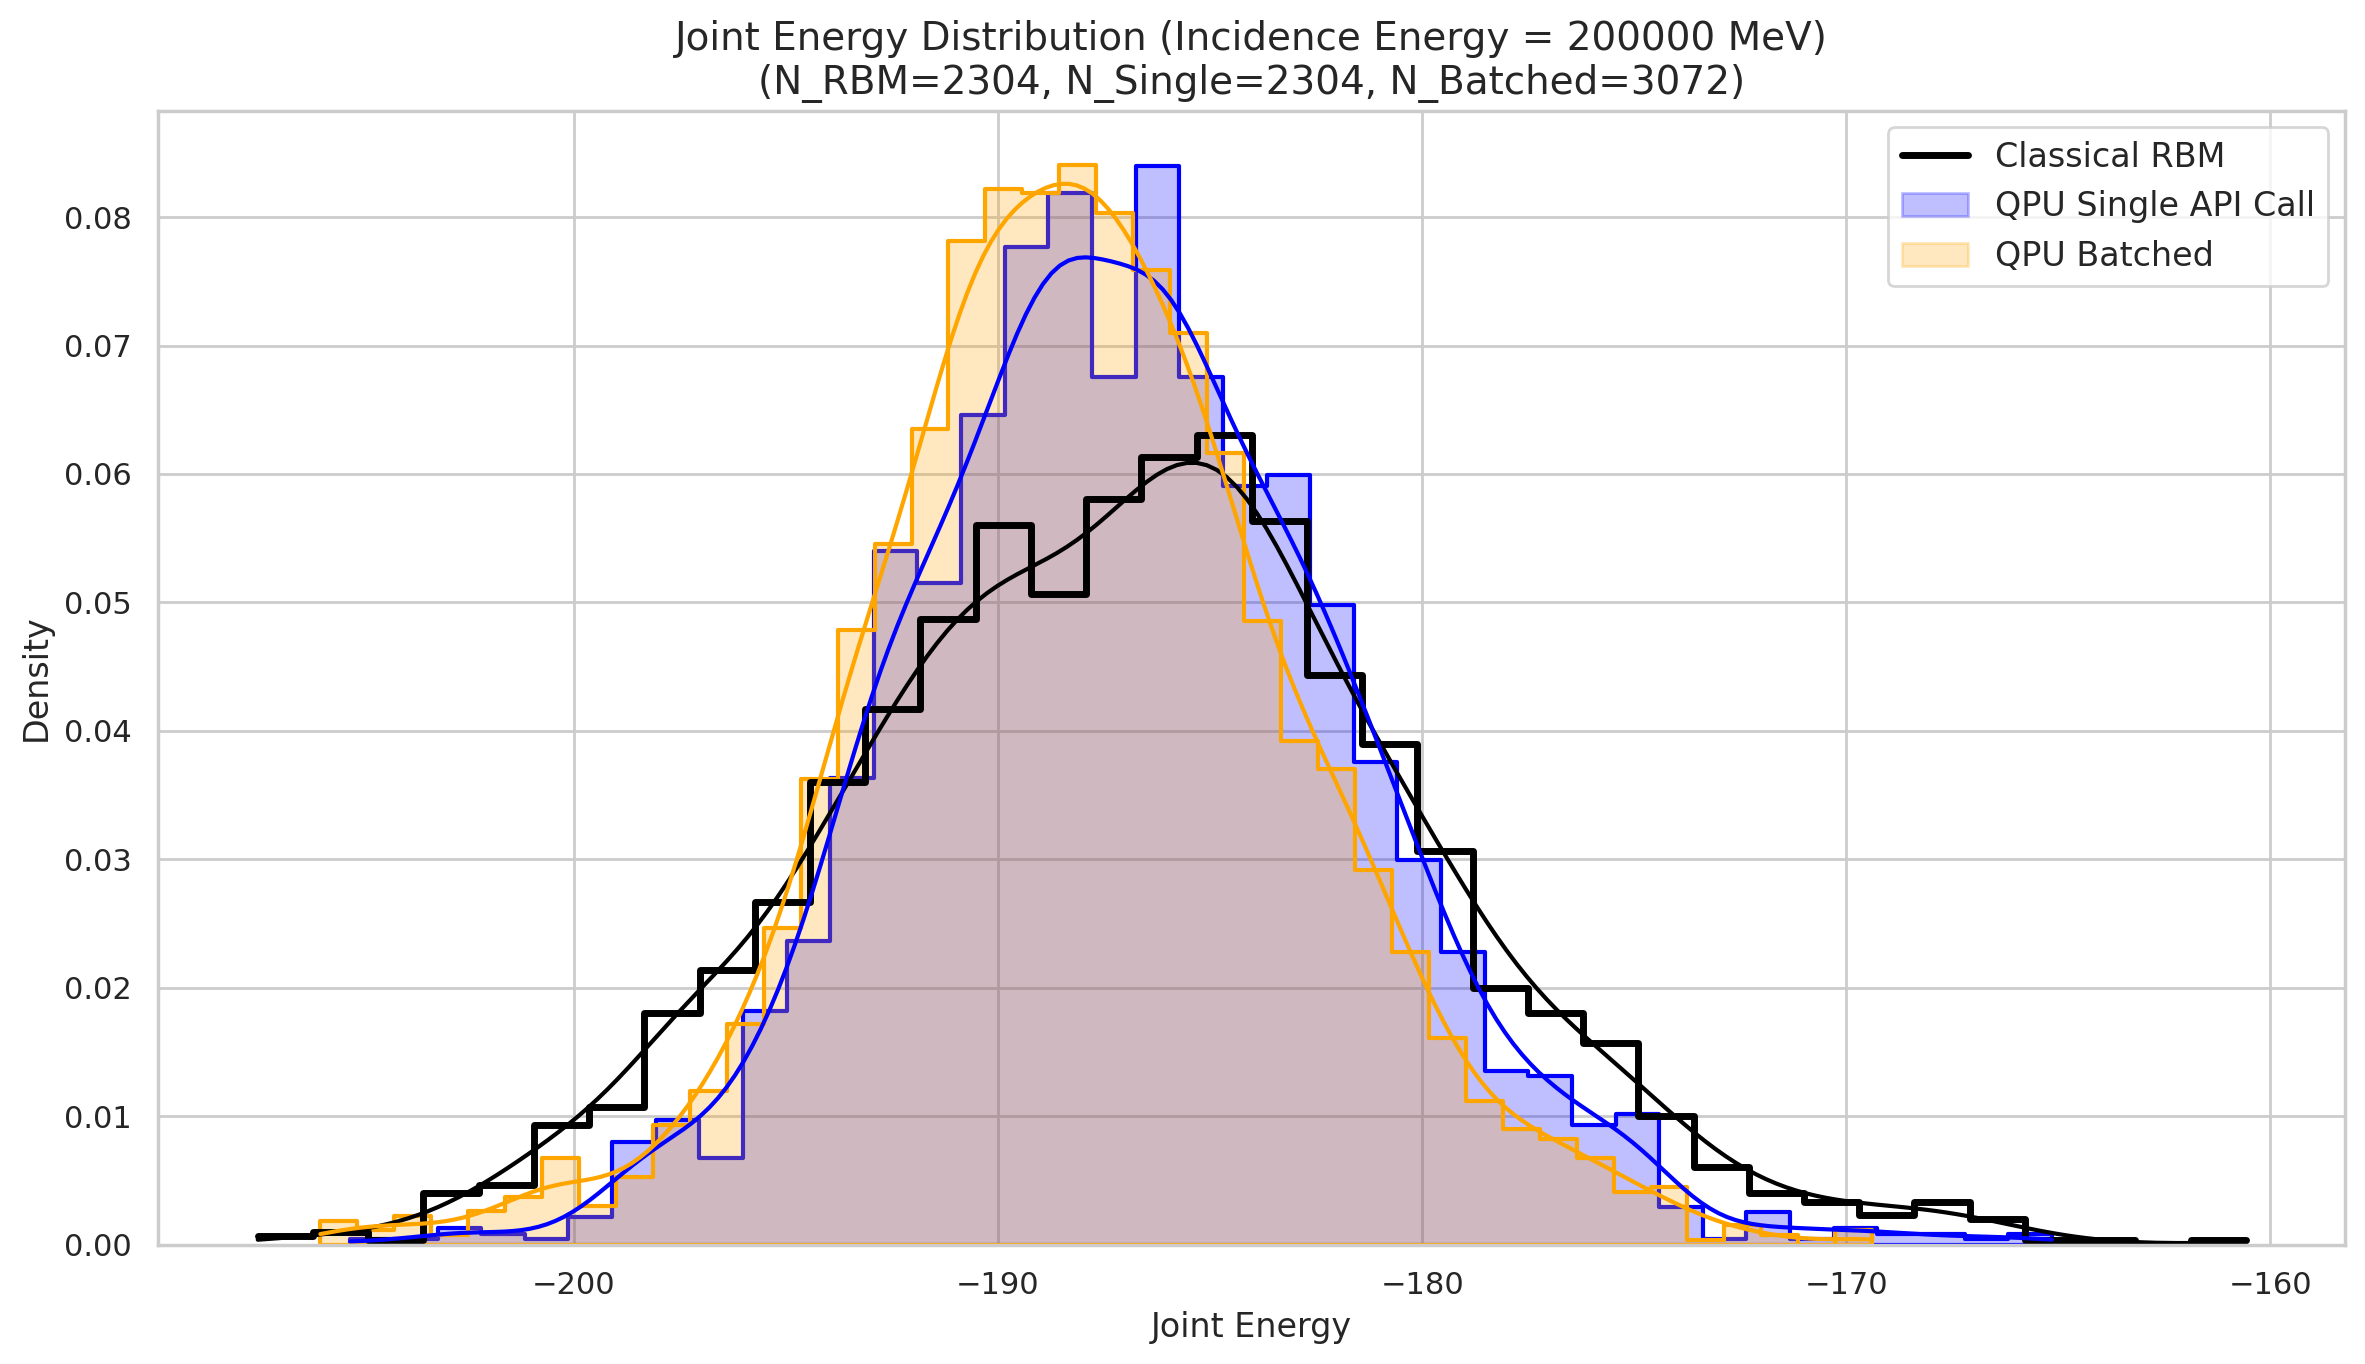

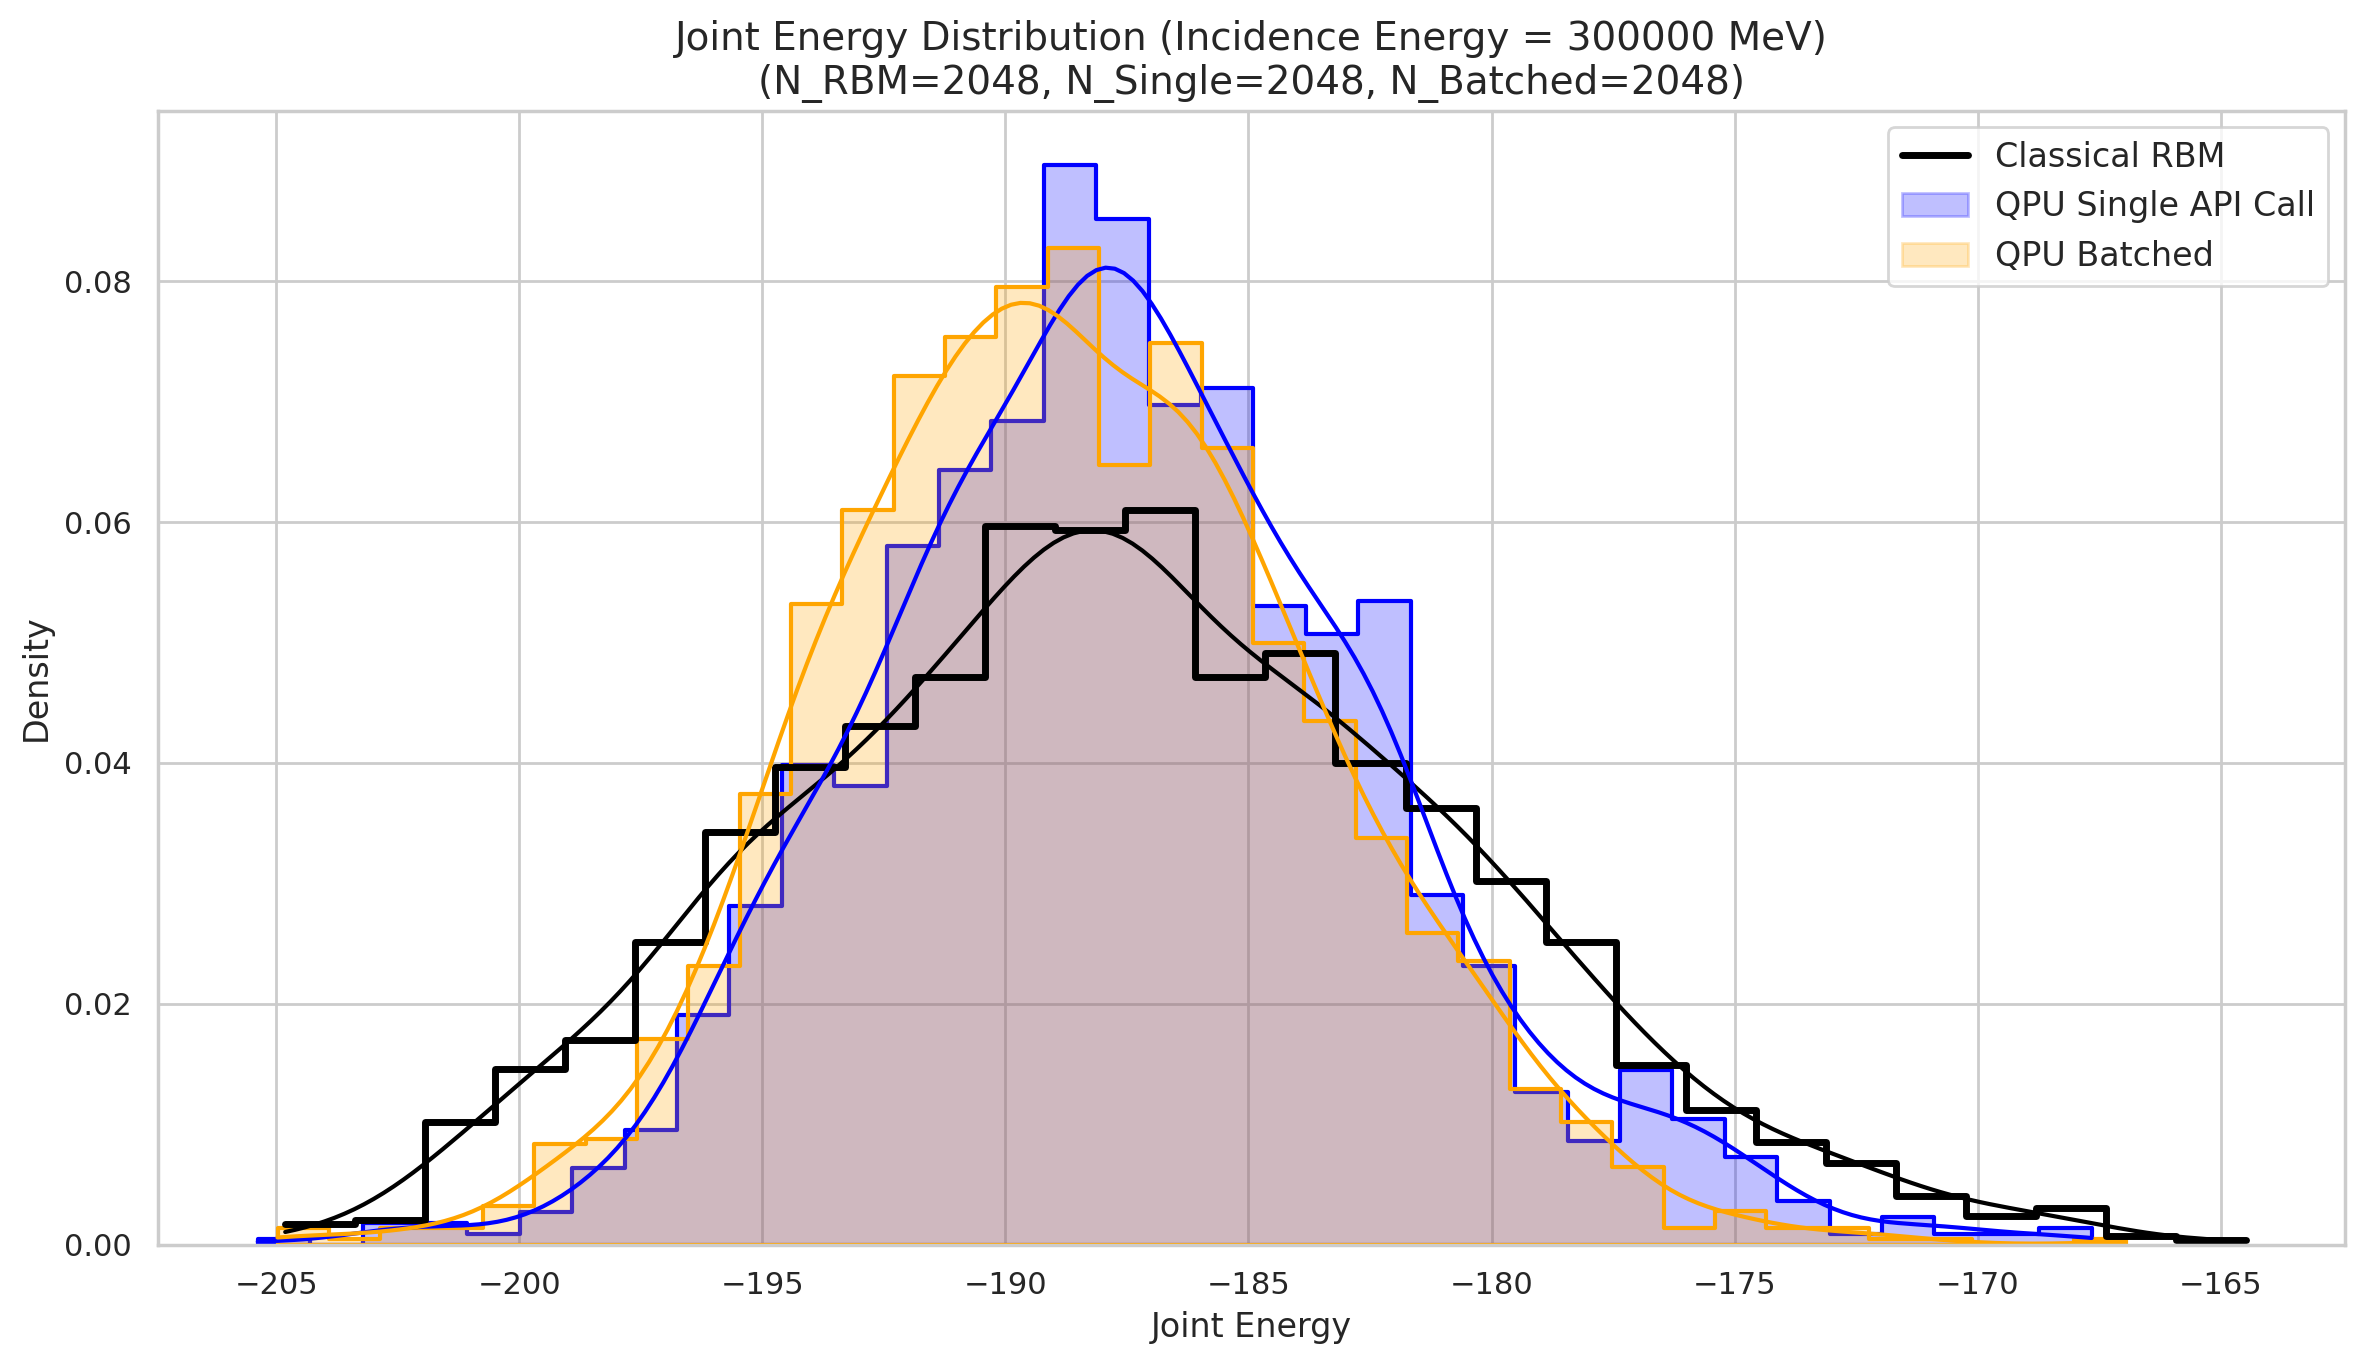

In [28]:
def get_conditioning_vector(runner, energy_val, device):
    """Helper to get the binary conditioning bits for the RBM."""
    e_tensor = torch.tensor([[energy_val]], dtype=torch.float32).to(device)
    num_clamped_bits = 53 # Matches script logic
    with torch.no_grad():
        bin_energy = runner.model.encoder.binary_energy_refactored(e_tensor)[:, :num_clamped_bits]
    return bin_energy

# --- Plotting Loop ---
for energy in INCIDENCE_ENERGIES:
    plt.figure(figsize=(12, 7))
    
    # 1. Load QPU Data
    qpu_energies = {}
    for mode in ['careful', 'fast']:
        f_path = os.path.join(PROCESSED_DIR, f"combined_E{energy}_{mode}.npz")
        if os.path.exists(f_path):
            data = np.load(f_path, allow_pickle=True)
            v_qpu = torch.tensor(data['v_samples'], dtype=torch.float32).to(device)
            h_qpu = torch.tensor(data['h_samples'], dtype=torch.float32).to(device)
            
            with torch.no_grad():
                E_vals = joint_energy(rbm, v_qpu, h_qpu).cpu().numpy()
                qpu_energies[mode] = E_vals
    
    if not qpu_energies:
        print(f"Skipping E={energy}")
        continue

    # 2. Generate Classical RBM Baseline
    n_samples_ref = len(qpu_energies.get('careful', qpu_energies.get('fast', [0]*1024)))
    
    cond_pattern = get_conditioning_vector(self, energy, device) 
    cond_batch = cond_pattern.repeat(n_samples_ref, 1)
    
    v_rbm = rbm.sample_v_given_v_clamped(
        clamped_v=cond_batch, 
        n_clamped=cond_pattern.shape[1], 
        gibbs_steps=100000, 
        beta=1.0
    )
    h_rbm, _ = rbm._sample_h_given_v(v_rbm, beta=1.0)
    
    with torch.no_grad():
        rbm_energies = joint_energy(rbm, v_rbm, h_rbm).cpu().numpy()

    # 3. Plotting with "Step" style for clear outlines
    
    # RBM: No fill, just a strong black outline
    sns.histplot(
        rbm_energies, color="black", stat="density", kde=True, 
        element="step", fill=False, linewidth=2.5, label="_nolegend_"
    )
    
    # QPU Careful: Blue fill with step outline
    if 'careful' in qpu_energies:
        sns.histplot(
            qpu_energies['careful'], color="blue", stat="density", kde=True, 
            element="step", alpha=0.25, linewidth=1.5, label="_nolegend_"
        )
        
    # QPU Fast: Orange fill with step outline
    if 'fast' in qpu_energies:
        sns.histplot(
            qpu_energies['fast'], color="orange", stat="density", kde=True, 
            element="step", alpha=0.25, linewidth=1.5, label="_nolegend_"
        )

    # 4. Custom Legend Construction
    legend_handles = [
        mlines.Line2D([], [], color='black', linewidth=2.5, label='Classical RBM'),
    ]
    if 'careful' in qpu_energies:
        legend_handles.append(mpatches.Patch(color='blue', alpha=0.25, label='QPU Single API Call'))
    if 'fast' in qpu_energies:
        legend_handles.append(mpatches.Patch(color='orange', alpha=0.25, label='QPU Batched'))

    # Construct Title with Counts
    count_str = f"N_RBM={n_samples_ref}"
    if 'careful' in qpu_energies:
        count_str += f", N_Single={len(qpu_energies['careful'])}"
    if 'fast' in qpu_energies:
        count_str += f", N_Batched={len(qpu_energies['fast'])}"

    plt.title(f"Joint Energy Distribution (Incidence Energy = {energy} MeV)\n({count_str})", fontsize=14)
    plt.xlabel("Joint Energy", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(handles=legend_handles, fontsize=12)
    
    plt.tight_layout()
    plt.show()

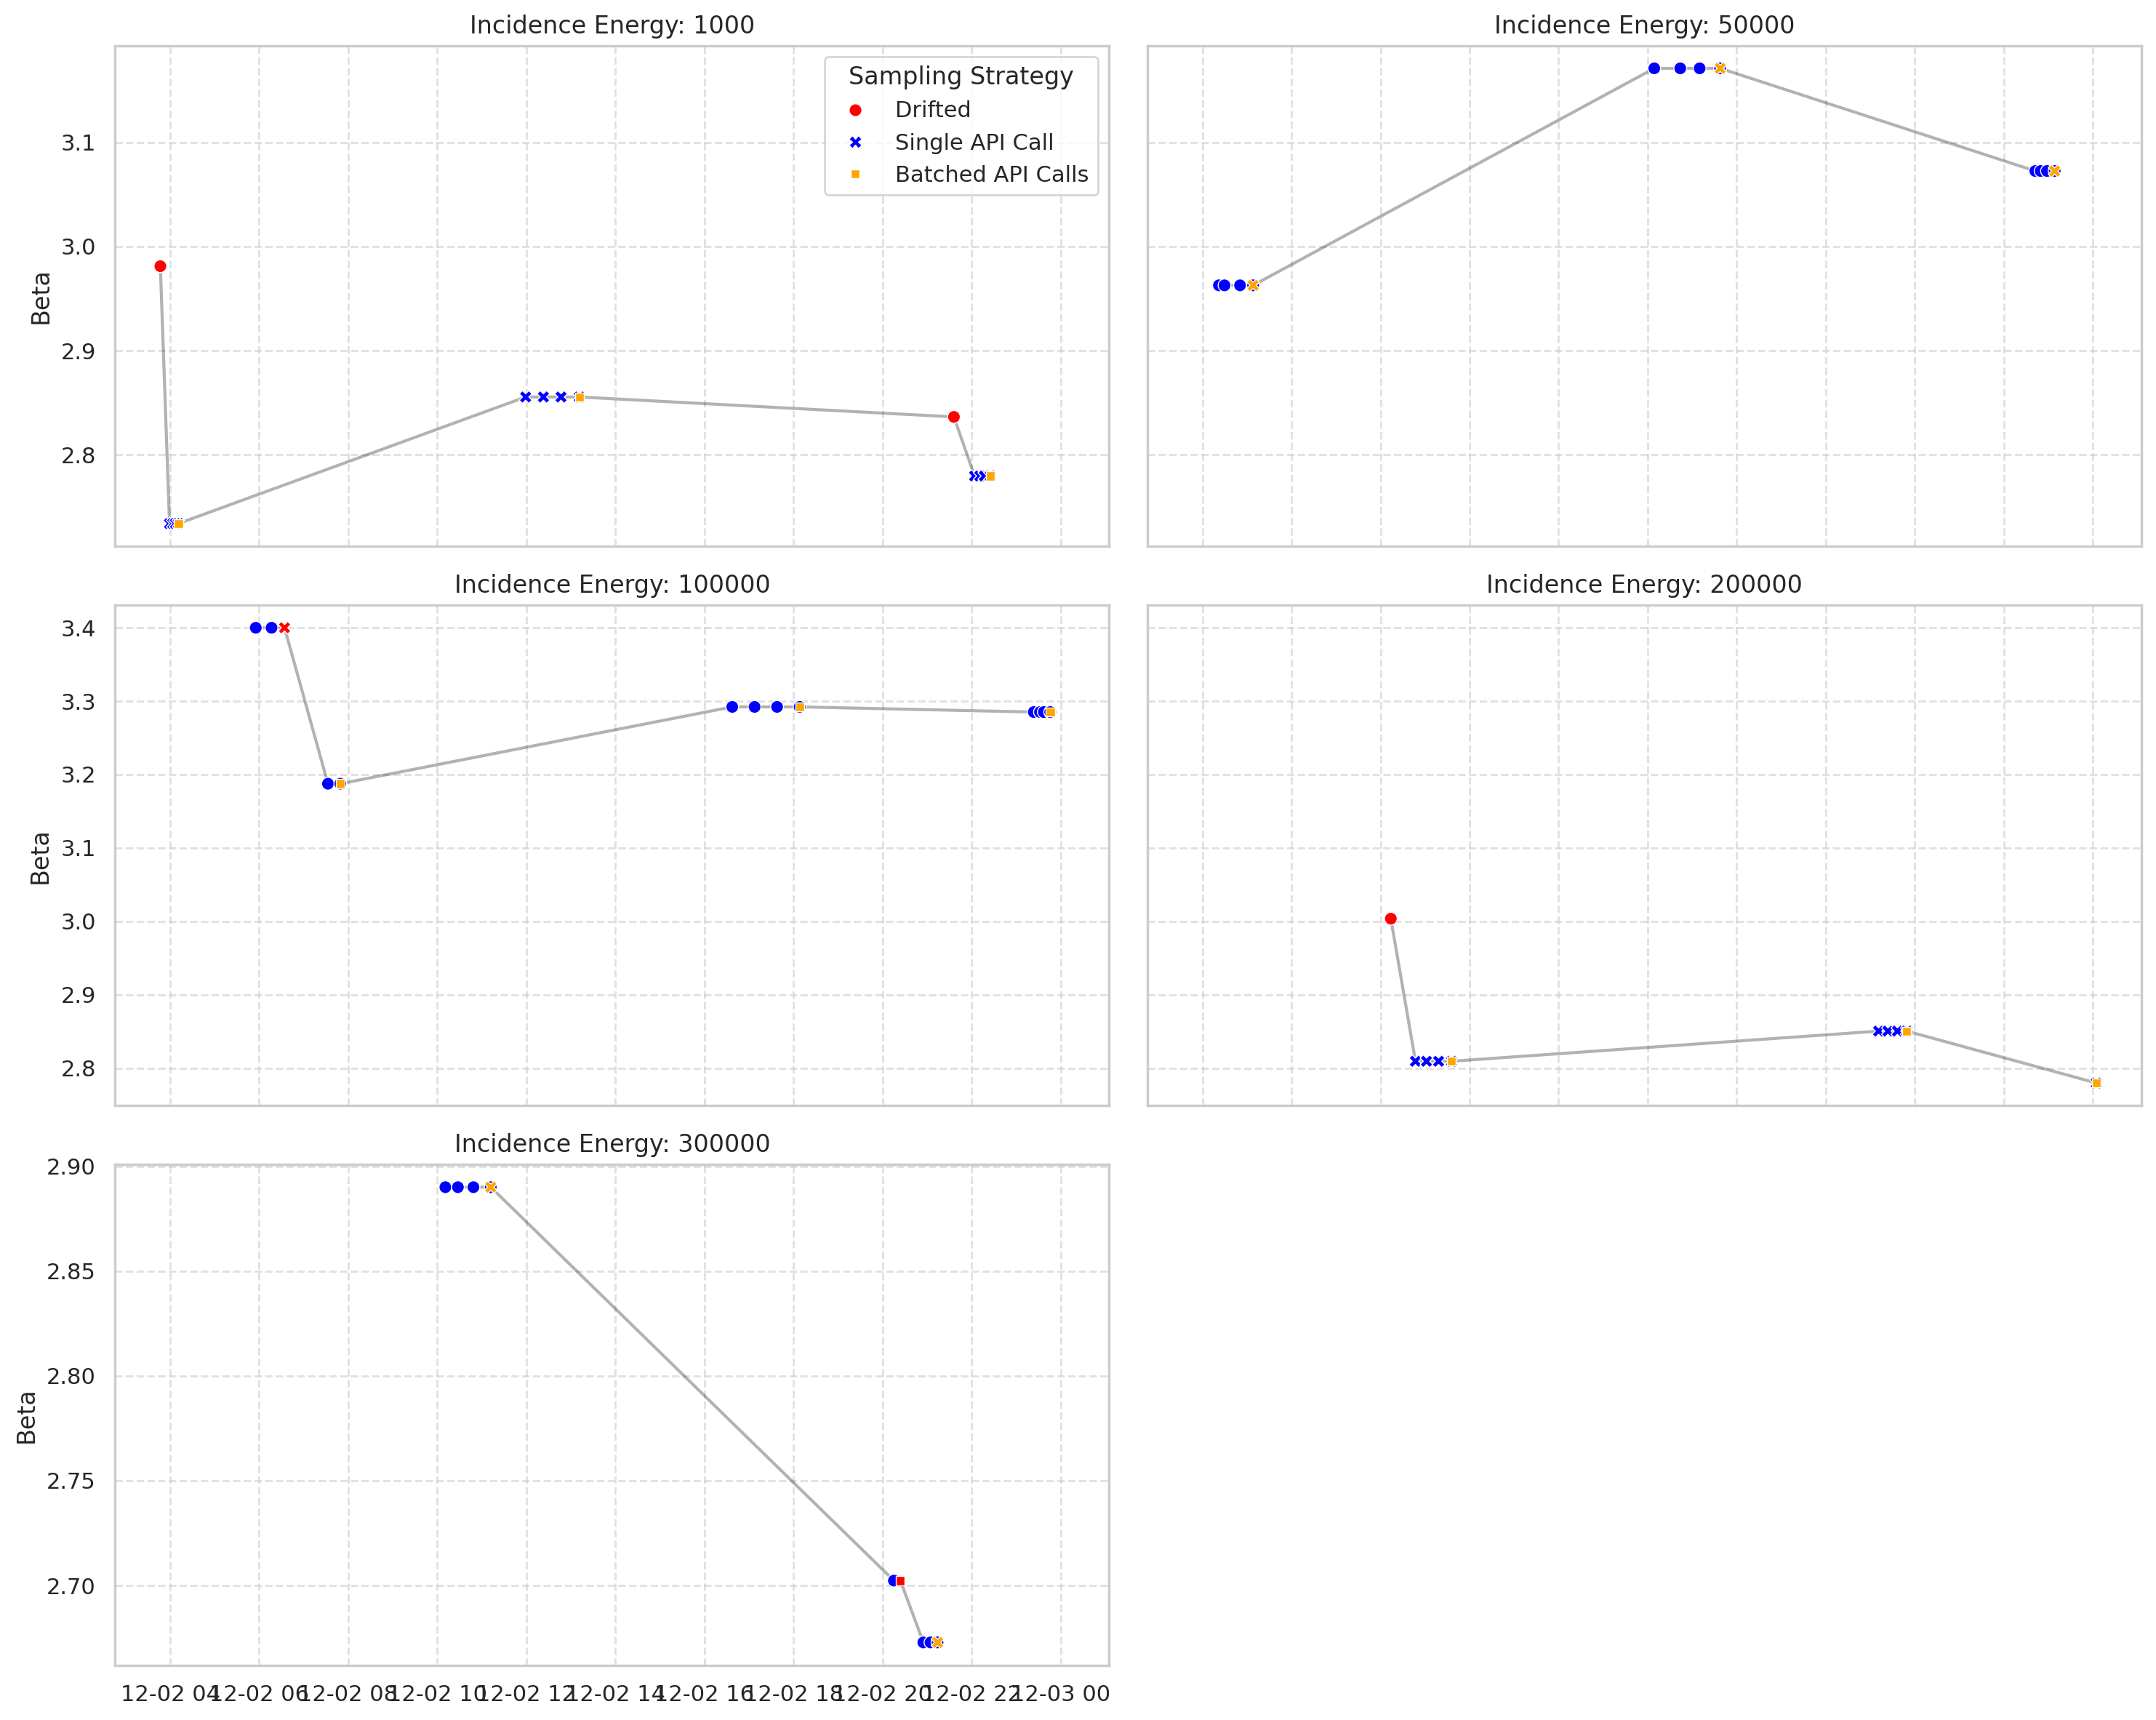

[01:54:23.391] INFO   matplotlib.category                               Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_827201/4162887460.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
[01:54:23.400] INFO   matplotlib.category                               Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


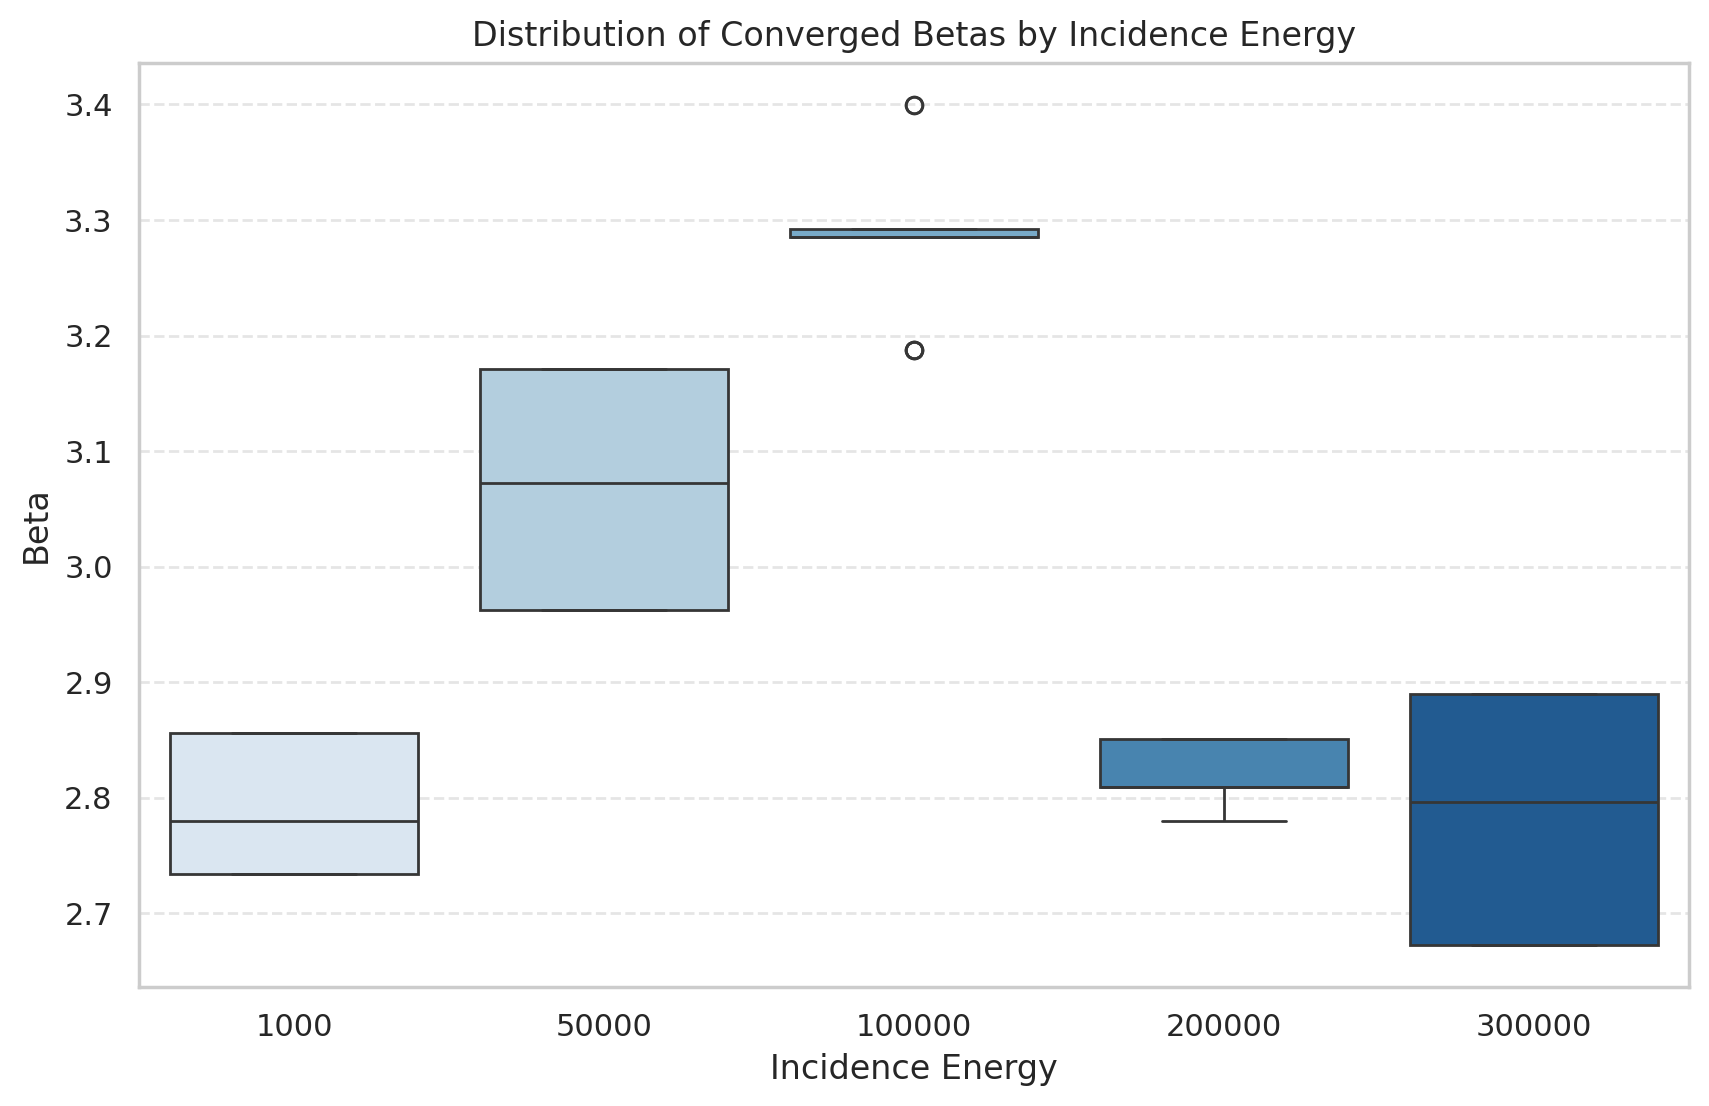

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Prepare the Data
df = pd.DataFrame({
    'beta': all_betas,
    'timestamp': all_times,
    'energy': all_energies,
    'mode': all_modes
})

# --- RENAME LEGEND LABELS ---
# Map raw mode strings to display labels
label_map = {
    'careful': 'Single API Call',
    'fast': 'Batched API Calls',
    'drifted': 'Drifted'
}
df['mode'] = df['mode'].map(label_map)

# Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create batch-level view (1 point per batch instead of per sample)
df_batch = df.drop_duplicates(subset=['timestamp', 'energy']).sort_values('timestamp')

# Define Palette using new labels
custom_palette = {
    'Single API Call': 'blue', 
    'Batched API Calls': 'orange', 
    'Drifted': 'red'
}

# ==========================================
# PART 1: Beta Evolution Grid (3x2)
# ==========================================
energies = sorted(list(set(df_batch['energy'].unique())), key=int)
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharey='row', sharex=True)
axes = axes.flatten()

for i, energy_val in enumerate(energies):
    ax = axes[i]
    subset = df_batch[df_batch['energy'] == str(energy_val)]
    
    if subset.empty:
        continue
        
    # Plot Trajectory Line
    sns.lineplot(
        data=subset, x='timestamp', y='beta', 
        ax=ax, color='black', alpha=0.3, linewidth=1.5, label='_nolegend_'
    )
    
    # Plot Points with New Labels
    sns.scatterplot(
        data=subset, x='timestamp', y='beta', hue='mode', style='mode',
        ax=ax, palette=custom_palette,
        s=40, zorder=10
    )
    
    ax.set_title(f"Incidence Energy: {energy_val}")
    ax.set_xlabel("")
    ax.set_ylabel("Beta")
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Fix Legend: Only show on first plot
    if i == 0:
        ax.legend(loc='upper right', title="Sampling Strategy")
    else:
        if ax.get_legend(): ax.get_legend().remove()

# Hide unused subplots
if len(energies) < 6:
    for j in range(len(energies), 6):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# ==========================================
# PART 2: Summary Box Plot
# ==========================================
plt.figure(figsize=(10, 6))

# Filter out 'Drifted' to show only the converged/working betas
stable_mask = df_batch['mode'] != 'Drifted'
stable_data = df_batch[stable_mask]

sns.boxplot(
    data=stable_data,
    x='energy', 
    y='beta', 
    order=[str(e) for e in INCIDENCE_ENERGIES], # Force correct numeric order
    palette="Blues"
)

plt.title("Distribution of Converged Betas by Incidence Energy")
plt.xlabel("Incidence Energy")
plt.ylabel("Beta")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

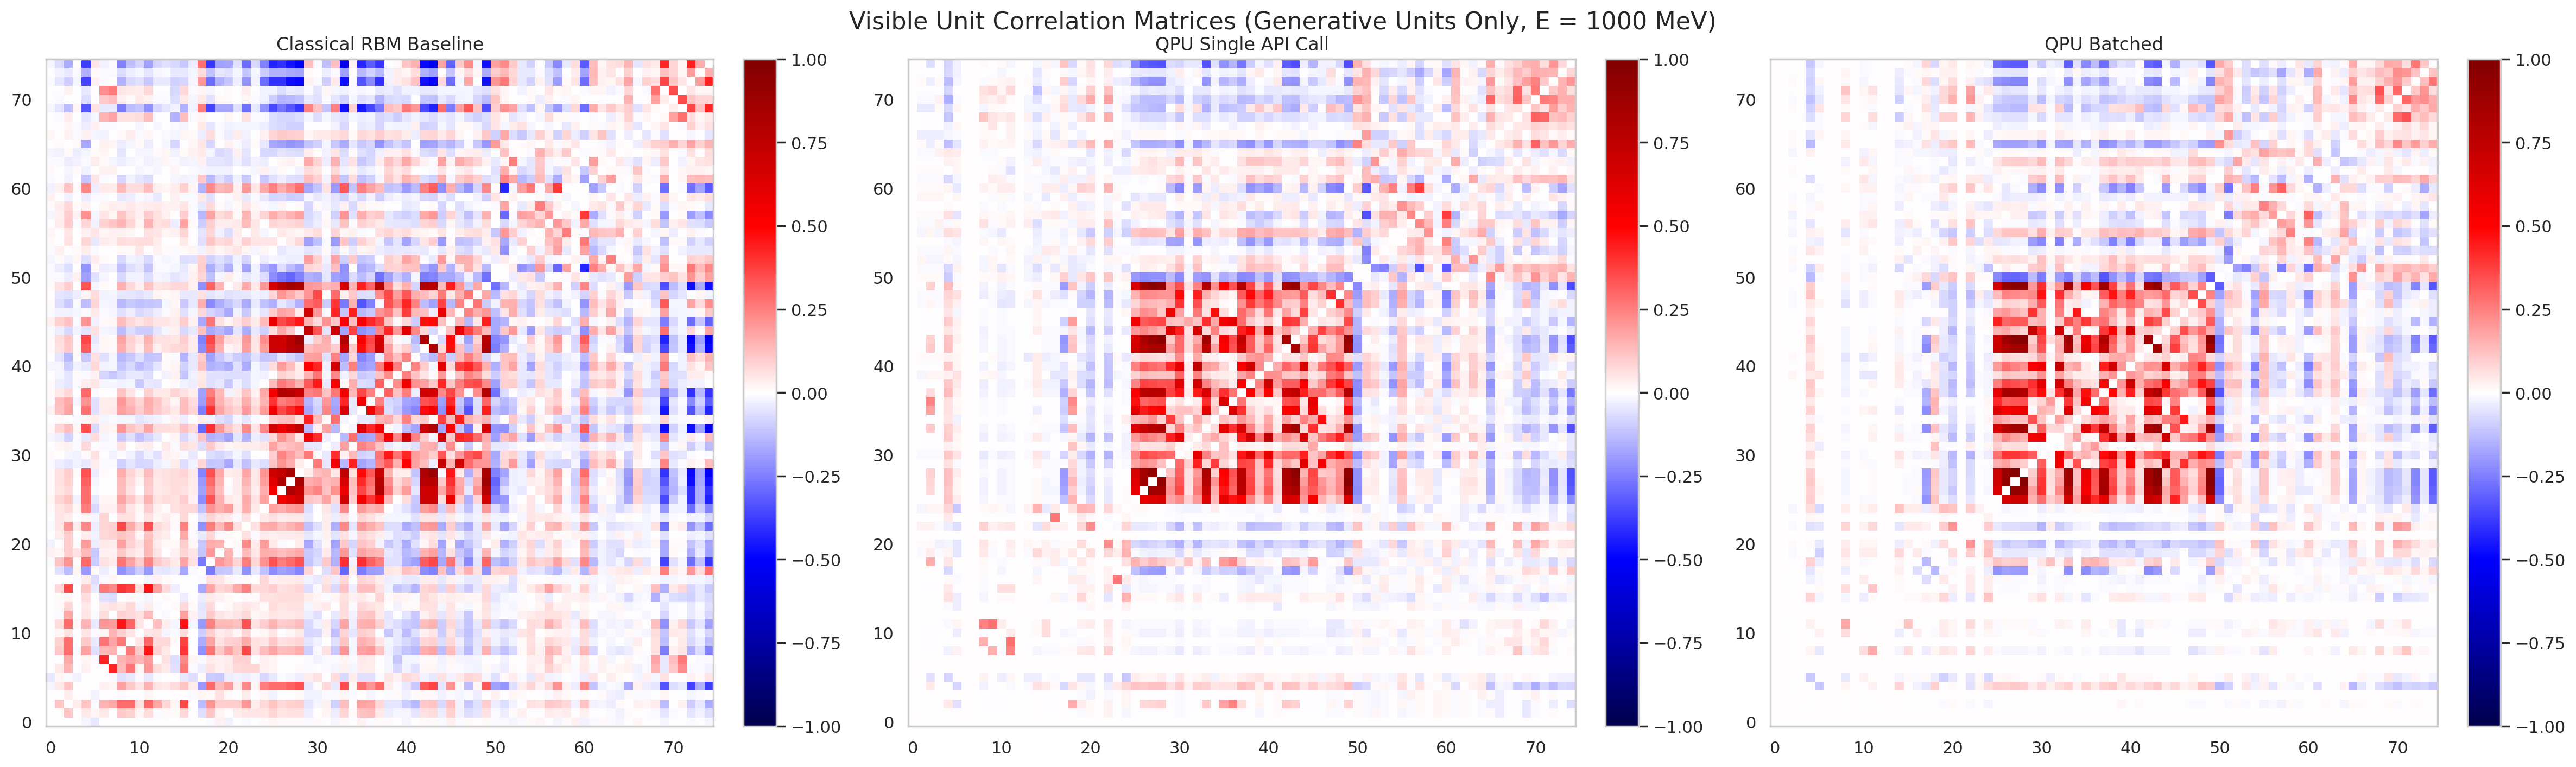

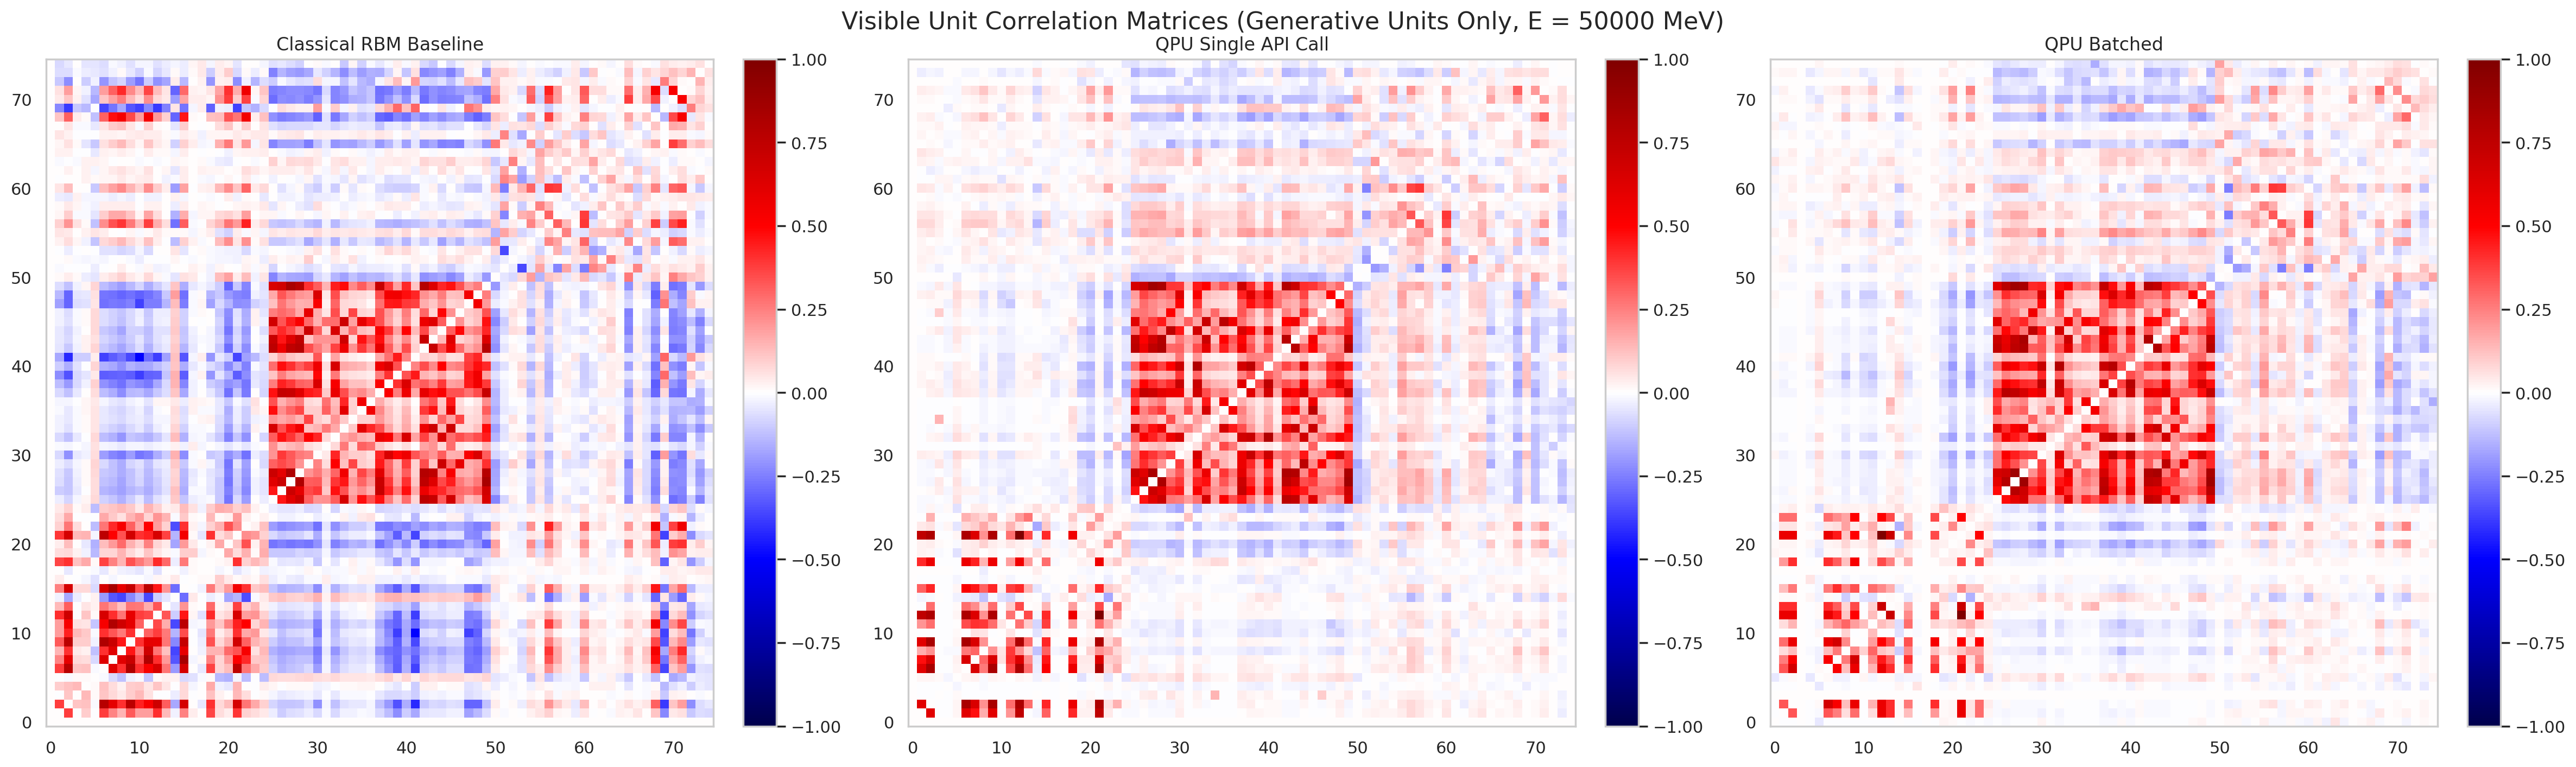

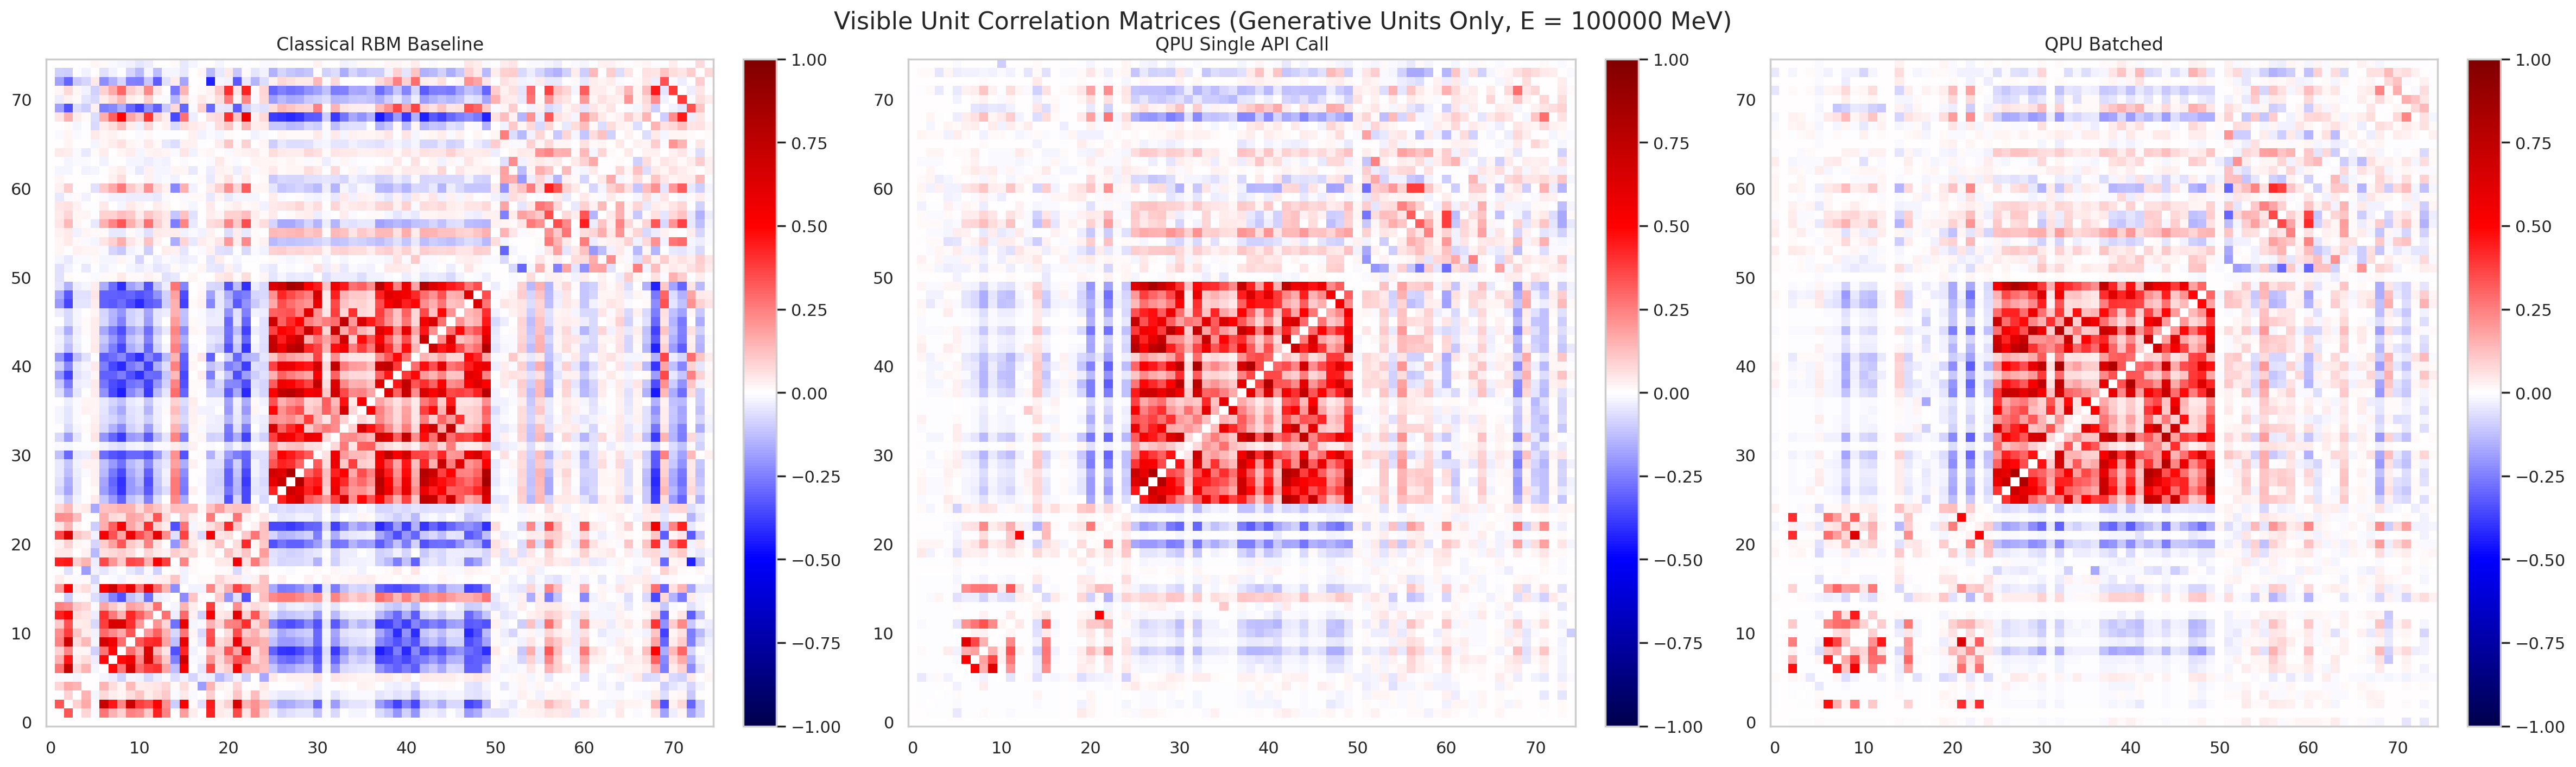

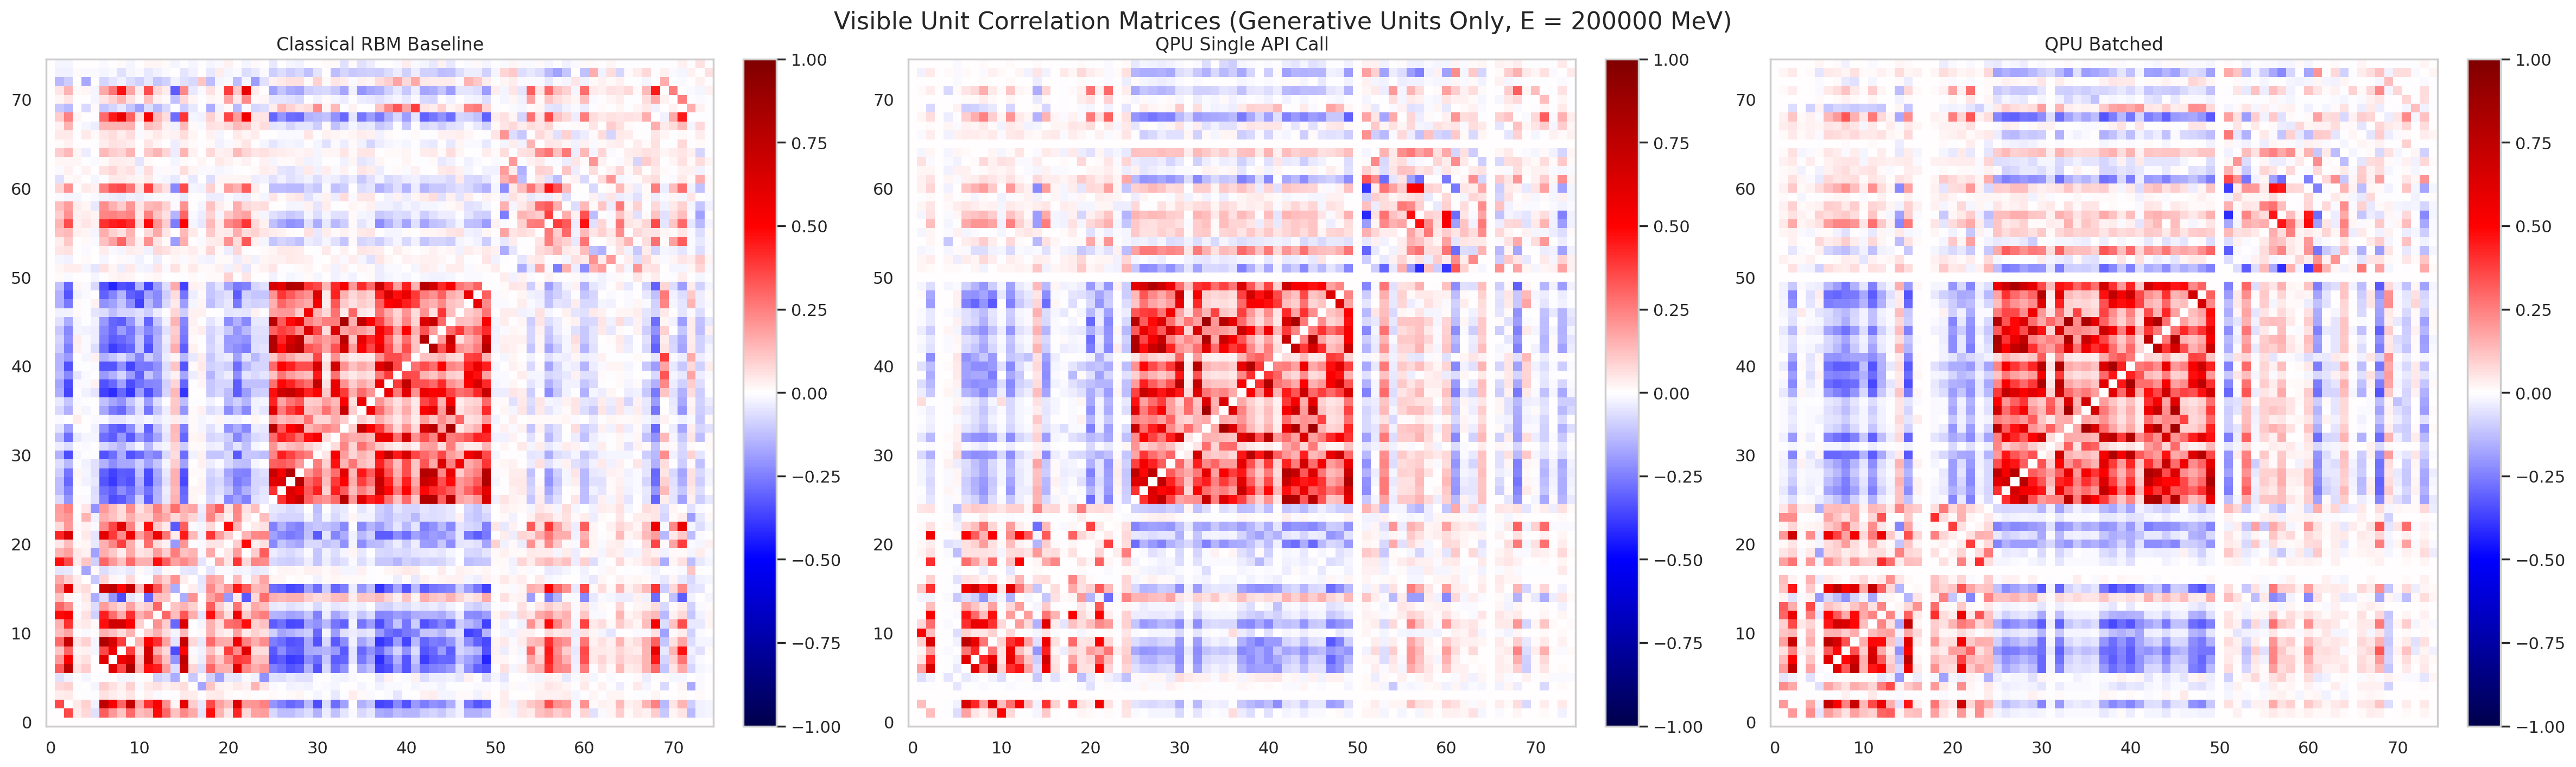

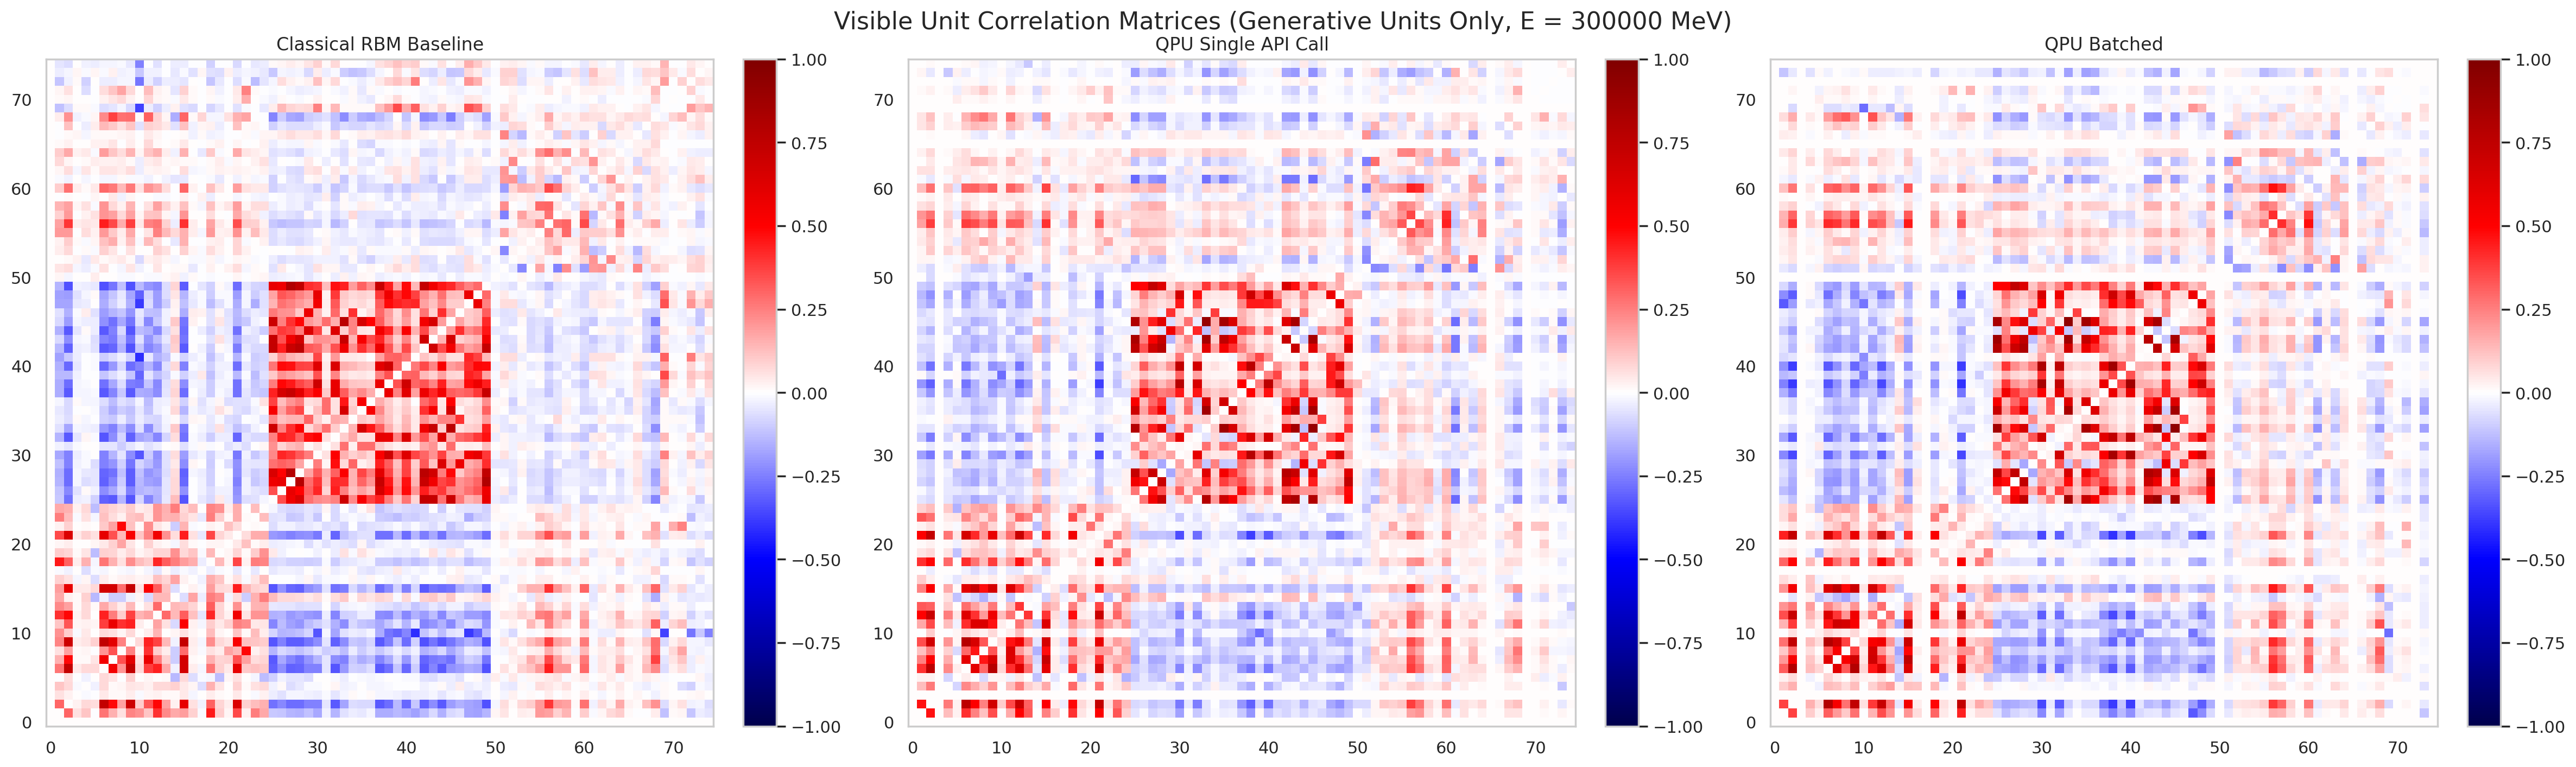

In [32]:
def plot_corr_matrix(ax, samples_tensor, title, n_clamped=53):
    """
    Calculates and plots the correlation matrix, cropped to exclude the 
    clamped conditioning bits (showing only the generative latent units).
    """
    # 1. Calculate Correlation
    if samples_tensor.is_cuda:
        samples_tensor = samples_tensor.cpu()
        
    # samples_tensor: (N_samples, N_features)
    corr = torch.corrcoef(samples_tensor.T).numpy()
    
    # 2. Crop the Matrix
    # We slice to remove the first n_clamped rows and columns
    corr = corr[n_clamped:, n_clamped:]
    
    # 3. Zero out Diagonal (of the cropped matrix)
    np.fill_diagonal(corr, 0)
    
    # 4. Handle NaNs
    corr = np.nan_to_num(corr, nan=0.0)
    
    # 5. Plot
    im = ax.imshow(corr, cmap='seismic', vmin=-1, vmax=1, interpolation="none")
    ax.invert_yaxis() 
    ax.set_title(title)
    ax.grid(False) 
    return im

# --- Main Loop ---
for energy in INCIDENCE_ENERGIES:
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    plt.suptitle(f"Visible Unit Correlation Matrices (Generative Units Only, E = {energy} MeV)", fontsize=16)
    
    data_map = {}
    
    # 1. Load QPU Data
    for mode in ['careful', 'fast']:
        f_path = os.path.join(PROCESSED_DIR, f"combined_E{energy}_{mode}.npz")
        if os.path.exists(f_path):
            d = np.load(f_path, allow_pickle=True)
            data_map[mode] = torch.tensor(d['v_samples'], dtype=torch.float32)

    # 2. Generate Classical RBM Baseline
    n_samples_ref = len(data_map.get('careful', torch.zeros(1024)))
    
    cond_pattern = get_conditioning_vector(self, energy, rbm.device) 
    cond_batch = cond_pattern.repeat(n_samples_ref, 1)
    
    v_rbm = rbm.sample_v_given_v_clamped(
        clamped_v=cond_batch, 
        n_clamped=cond_pattern.shape[1], 
        gibbs_steps=5000, 
        beta=1.0
    )
    data_map['classical'] = v_rbm.cpu()
    
    # --- 3. Plotting ---
    
    # Subplot 1: Classical
    if 'classical' in data_map:
        im = plot_corr_matrix(axes[0], data_map['classical'], "Classical RBM Baseline")
        fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
        
    # Subplot 2: QPU Single API Call
    if 'careful' in data_map:
        im = plot_corr_matrix(axes[1], data_map['careful'], "QPU Single API Call")
        fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    else:
        axes[1].text(0.5, 0.5, "No Data", ha='center', fontsize=12)
        axes[1].axis('off')

    # Subplot 3: QPU Batched
    if 'fast' in data_map:
        im = plot_corr_matrix(axes[2], data_map['fast'], "QPU Batched")
        fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    else:
        axes[2].text(0.5, 0.5, "No Data", ha='center', fontsize=12)
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()